In [1]:
import numpy as np
import gsw
import sys
import xray
import os
from scipy import io
from scipy import stats
# from scipy import ndimage
# from scipy import linalg
# from netCDF4 import Dataset

# from scipy.interpolate import interp2d, RectBivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/takaya/sst_analysis/Idealized_Model/')
import gfd

In [2]:
npzfile = np.load('POP_1st_BarocliRadii_10deg.npz')
print npzfile.files
Radii = npzfile['Radii']
Lon10 = npzfile['Lon']
Lat10 = npzfile['Lat']

['Lat', 'Radii', 'Lon']


In [4]:
npzfile = np.load('KE_January_parallel_YS.npz')
print npzfile.files
Spectra_Jan_u = npzfile['PSD_u']
Spectra_Jan_v = npzfile['PSD_v']
Kis = npzfile['Ki']
Neff_Jan = npzfile['Deg_Freedom']

npzfile = np.load('KE_February_parallel_YS.npz')
print npzfile.files
Spectra_Feb_u = npzfile['PSD_u']
Spectra_Feb_v = npzfile['PSD_v']
Neff_Feb = npzfile['Deg_Freedom']

npzfile = np.load('KE_March_parallel_YS.npz')
print npzfile.files
Spectra_Mar_u = npzfile['PSD_u']
Spectra_Mar_v = npzfile['PSD_v']
Neff_Mar = npzfile['Deg_Freedom']

npzfile = np.load('KE_April_parallel_YS.npz')
print npzfile.files
Spectra_Apr_u = npzfile['PSD_u']
Spectra_Apr_v = npzfile['PSD_v']
Neff_Apr = npzfile['Deg_Freedom']

npzfile = np.load('KE_May_parallel_YS.npz')
print npzfile.files
Spectra_May_u = npzfile['PSD_u']
Spectra_May_v = npzfile['PSD_v']
Neff_May = npzfile['Deg_Freedom']

npzfile = np.load('KE_June_parallel_YS.npz')
print npzfile.files
Spectra_Jun_u = npzfile['PSD_u']
Spectra_Jun_v = npzfile['PSD_v']
Neff_Jun = npzfile['Deg_Freedom']

npzfile = np.load('KE_July_parallel_YS.npz')
print npzfile.files
Spectra_Jul_u = npzfile['PSD_u']
Spectra_Jul_v = npzfile['PSD_v']
Neff_Jul = npzfile['Deg_Freedom']

npzfile = np.load('KE_August_parallel_YS.npz')
print npzfile.files
Spectra_Aug_u = npzfile['PSD_u']
Spectra_Aug_v = npzfile['PSD_v']
Neff_Aug = npzfile['Deg_Freedom']

npzfile = np.load('KE_September_parallel_YS.npz')
print npzfile.files
Spectra_Sep_u = npzfile['PSD_u']
Spectra_Sep_v = npzfile['PSD_v']
Neff_Sep = npzfile['Deg_Freedom']

npzfile = np.load('KE_October_parallel_YS.npz')
print npzfile.files
Spectra_Oct_u = npzfile['PSD_u']
Spectra_Oct_v = npzfile['PSD_v']
Neff_Oct = npzfile['Deg_Freedom']

npzfile = np.load('KE_November_parallel_YS.npz')
print npzfile.files
Spectra_Nov_u = npzfile['PSD_u']
Spectra_Nov_v = npzfile['PSD_v']
Neff_Nov = npzfile['Deg_Freedom']

npzfile = np.load('KE_December_parallel_YS.npz')
print npzfile.files
Spectra_Dec_u = npzfile['PSD_u']
Spectra_Dec_v = npzfile['PSD_v']
Neff_Dec = npzfile['Deg_Freedom']

['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']
['PSD_u', 'Ki', 'PSD_v', 'Deg_Freedom']


In [5]:
def linear_regression_stats(x,y,constant,slope,alfa):

    from scipy import stats
    p_y = slope * x + constant
    n = len(x)              # number of samples in origional fit
    t = stats.t.ppf(1-alfa/2, n-2) # appropriate t value (where n-2 because two params, y and x), alfa/2 because it is a two tailed test
    # calculate the y-error (residuals)
    y_err = y - p_y
    # now calculate standard_error
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
 
    mean_x = np.mean(x)         # mean of x
    #standard error of slope
    se_slope = np.sqrt(s_err/(n-2))/np.sqrt(np.sum(np.power((x-mean_x),2)))
    #standard error of intercept
    se_intercept = se_slope*np.sqrt((1./n)*np.sum(x**2))
    #margin error - this is ultimately the quantity that you add/subtract to your estimate to get the CI
    me_slope = se_slope*t
    me_intercept = se_intercept*t
    
    # here i calculate the p-value of the t-statistics of your slope. The smallest the number (at least less than 
    # your alpha/2) the more significant and robust is your estimate.
    std_err = se_slope
    t_stats = slope/std_err
    p_value = (1-stats.t.cdf(np.abs(t_stats), n-2))*2 # it is a two tailed test

    return me_slope, me_intercept, std_err, t_stats, p_value

In [6]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0], p[1]

In [7]:
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
dlat, dlon = (10., 10.)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

psd_slopes_win_S = np.empty((Degy+1,Degx+1))
psd_levels_win_S = np.empty((Degy+1,Degx+1))
psd_slopeerr_win_S = np.empty((Degy+1,Degx+1))
psd_levelerr_win_S = np.empty((Degy+1,Degx+1))
psd_fit_win_S = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_win_S[:] = np.nan
psd_levels_win_S[:] = np.nan
psd_slopeerr_win_S[:] = np.nan
psd_levelerr_win_S[:] = np.nan
psd_fit_win_S[:] = np.nan
psd_slopes_win_M = np.empty((Degy+1,Degx+1))
psd_levels_win_M = np.empty((Degy+1,Degx+1))
psd_slopeerr_win_M = np.empty((Degy+1,Degx+1))
psd_levelerr_win_M = np.empty((Degy+1,Degx+1))
psd_fit_win_M = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_win_M[:] = np.nan
psd_levels_win_M[:] = np.nan
psd_slopeerr_win_M[:] = np.nan
psd_levelerr_win_M[:] = np.nan
psd_fit_win_M[:] = np.nan
psd_slopes_win_L = np.empty((Degy+1,Degx+1))
psd_levels_win_L = np.empty((Degy+1,Degx+1))
psd_slopeerr_win_L = np.empty((Degy+1,Degx+1))
psd_levelerr_win_L = np.empty((Degy+1,Degx+1))
psd_fit_win_L = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_win_L[:] = np.nan
psd_levels_win_L[:] = np.nan
psd_slopeerr_win_L[:] = np.nan
psd_levelerr_win_L[:] = np.nan
psd_fit_win_L[:] = np.nan

In [8]:
isospecs_ave_win = .5*( (Spectra_Jan_u+Spectra_Jan_v) + (Spectra_Feb_u+Spectra_Feb_v) + (Spectra_Mar_u+Spectra_Mar_v) )/3.
print isospecs_ave_win.shape
alpha = 0.05
for j in range(Degy+1):
    for i in range(Degx+1):
        
        if .3*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
            r03 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .3*Radii[j,i] )).argmin()
#             print r5
            if np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i, r03:])) == False:
#                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
                ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r03:], isospecs_ave_win[(Degx+1)*j+i, r03:])
                slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r03:]), np.log2(isospecs_ave_win[(Degx+1)*j+i, r03:]), ps_intercept, ps_slope, alpha)
                psd_slopes_win_S[j,i] = ps_slope
                psd_slopeerr_win_S[j,i] = slope_err
                psd_levels_win_S[j,i] = ps_fit[-1]
                psd_fit_win_S[r03:,j,i] = ps_fit
#                     else:
#                         #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                         psd_slopes_Feb_global[j,i] = np.NAN
#                         psd_levels_Feb_global[j,i] = np.NAN
        
            if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
                if np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i, r:r03])) == False:
#                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
                    ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r03], isospecs_ave_win[(Degx+1)*j+i, r:r03])
                    slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r:r03]), np.log2(isospecs_ave_win[(Degx+1)*j+i, r:r03]), ps_intercept, ps_slope, alpha)
                    psd_slopes_win_M[j,i] = ps_slope
                    psd_slopeerr_win_M[j,i] = slope_err
                    psd_levels_win_M[j,i] = ps_fit[-1]
                    psd_fit_win_M[r:r03,j,i] = ps_fit
#                 psd_levelerr_win[j.i] = 
                
#             else:
#                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                 psd_slopes_win_global[j,i] = np.NAN
#                 psd_levels_win_global[j,i] = np.NAN
            
                if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                    r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
                    if np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i, r2:r+1])) == False:
#                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
                        ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_win[(Degx+1)*j+i, r2:r+1])
                        slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_win[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
                        psd_slopes_win_L[j,i] = ps_slope
                        psd_slopeerr_win_L[j,i] = slope_err
                        psd_levels_win_L[j,i] = ps_fit[-1]
                        psd_fit_win_L[r2:r+1,j,i] = ps_fit
#                 else:
#                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                     psd_slopes_Feb_global[j,i] = np.NAN
#                     psd_levels_Feb_global[j,i] = np.NAN
            


(420, 128)


In [9]:
from tempfile import TemporaryFile
POP_KE_Winter_Polyfit_RossbyRadii = TemporaryFile()
np.savez('POP_KE_Winter_Polyfit_RossbyRadii', 
         isospec_spectra=isospecs_ave_win,
         Slopes_0to03Radii=psd_slopes_win_S, Level_0to03Radii=psd_levels_win_S, SlopeError_0to03Radii=psd_slopeerr_win_S, LevelError_0to03Radii=psd_levelerr_win_S, Fit_0to03Radii=psd_fit_win_S,
         Slopes_03to1Radii=psd_slopes_win_M, Level_03to1Radii=psd_levels_win_M, SlopeError_03to1Radii=psd_slopeerr_win_M, LevelError_03to1Radii=psd_levelerr_win_M, Fit_03to1Radii=psd_fit_win_M,
        Slopes_1to2Radii=psd_slopes_win_L, Level_1to2Radii=psd_levels_win_L, SlopeError_1to2Radii=psd_slopeerr_win_L, LevelError_1to2Radii=psd_levelerr_win_L, Fit_1to2Radii=psd_fit_win_L,
        )
POP_KE_Winter_Polyfit_RossbyRadii.seek(0)

In [10]:
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
dlat, dlon = (10., 10.)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

psd_slopes_sum_S = np.empty((Degy+1,Degx+1))
psd_levels_sum_S = np.empty((Degy+1,Degx+1))
psd_slopeerr_sum_S = np.empty((Degy+1,Degx+1))
psd_levelerr_sum_S = np.empty((Degy+1,Degx+1))
psd_fit_sum_S = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_sum_S[:] = np.nan
psd_levels_sum_S[:] = np.nan
psd_slopeerr_sum_S[:] = np.nan
psd_levelerr_sum_S[:] = np.nan
psd_fit_sum_S[:] = np.nan
psd_slopes_sum_M = np.empty((Degy+1,Degx+1))
psd_levels_sum_M = np.empty((Degy+1,Degx+1))
psd_slopeerr_sum_M = np.empty((Degy+1,Degx+1))
psd_levelerr_sum_M = np.empty((Degy+1,Degx+1))
psd_fit_sum_M = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_sum_M[:] = np.nan
psd_levels_sum_M[:] = np.nan
psd_slopeerr_sum_M[:] = np.nan
psd_levelerr_sum_M[:] = np.nan
psd_fit_sum_M[:] = np.nan
psd_slopes_sum_L = np.empty((Degy+1,Degx+1))
psd_levels_sum_L = np.empty((Degy+1,Degx+1))
psd_slopeerr_sum_L = np.empty((Degy+1,Degx+1))
psd_levelerr_sum_L = np.empty((Degy+1,Degx+1))
psd_fit_sum_L = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_sum_L[:] = np.nan
psd_levels_sum_L[:] = np.nan
psd_slopeerr_sum_L[:] = np.nan
psd_levelerr_sum_L[:] = np.nan
psd_fit_sum_L[:] = np.nan

In [12]:
isospecs_ave_sum = .5 * ( (Spectra_Jul_u+Spectra_Jul_v) + (Spectra_Aug_u+Spectra_Aug_v) + (Spectra_Sep_u+Spectra_Sep_v) ) / 3.
print isospecs_ave_sum.shape
alpha = 0.05
for j in range(Degy+1):
    for i in range(Degx+1):
        
        if .3*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
            r03 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .3*Radii[j,i] )).argmin()
#                     print r4, 4.*Radii[j,i]
            if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i, r03:])) == False:
#                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
                ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r03:], isospecs_ave_sum[(Degx+1)*j+i, r03:])
                slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r03:]), np.log2(isospecs_ave_sum[(Degx+1)*j+i, r03:]), ps_intercept, ps_slope, alpha)
                psd_slopes_sum_S[j,i] = ps_slope
                psd_slopeerr_sum_S[j,i] = slope_err
                psd_levels_sum_S[j,i] = ps_fit[-1]
                psd_fit_sum_S[r03:,j,i] = ps_fit
        
            if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
#             print r, Radii[j,i]
                if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i, r:r03])) == False:
#                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
                    ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r03], isospecs_ave_sum[(Degx+1)*j+i, r:r03])
                    slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r:r03]), np.log2(isospecs_ave_sum[(Degx+1)*j+i, r:r03]), ps_intercept, ps_slope, alpha)
                    psd_slopes_sum_M[j,i] = ps_slope
                    psd_slopeerr_sum_M[j,i] = slope_err
                    psd_levels_sum_M[j,i] = ps_fit[-1]
                    psd_fit_sum_M[r:r03,j,i] = ps_fit
#                 psd_levelerr_win[j.i] = 
                
#             else:
#                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                 psd_slopes_win_global[j,i] = np.NAN
#                 psd_levels_win_global[j,i] = np.NAN
            
                if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                    r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
#                 print r2, 2.*Radii[j,i]
                    if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i, r2:r+1])) == False:
#                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
                        ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_sum[(Degx+1)*j+i, r2:r+1])
                        slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_sum[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
                        psd_slopes_sum_L[j,i] = ps_slope
                        psd_slopeerr_sum_L[j,i] = slope_err
                        psd_levels_sum_L[j,i] = ps_fit[-1]
                        psd_fit_sum_L[r2:r+1,j,i] = ps_fit
#                 else:
#                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                     psd_slopes_Feb_global[j,i] = np.NAN
#                     psd_levels_Feb_global[j,i] = np.NAN
            


(420, 128)


In [13]:
from tempfile import TemporaryFile
POP_KE_Summer_Polyfit_RossbyRadii = TemporaryFile()
np.savez('POP_KE_Summer_Polyfit_RossbyRadii', 
         isospec_spectra=isospecs_ave_sum,
         Slopes_0to03Radii=psd_slopes_sum_S, Level_0to03Radii=psd_levels_sum_S, SlopeError_0to03Radii=psd_slopeerr_sum_S, LevelError_0to03Radii=psd_levelerr_sum_S, Fit_0to03Radii=psd_fit_sum_S,
         Slopes_03to1Radii=psd_slopes_sum_M, Level_03to1Radii=psd_levels_sum_M, SlopeError_03to1Radii=psd_slopeerr_sum_M, LevelError_03to1Radii=psd_levelerr_sum_M, Fit_03to1Radii=psd_fit_sum_M,
        Slopes_1to2Radii=psd_slopes_sum_L, Level_1to2Radii=psd_levels_sum_L, SlopeError_1to2Radii=psd_slopeerr_sum_L, LevelError_1to2Radii=psd_levelerr_sum_L, Fit_1to2Radii=psd_fit_sum_L
        )
POP_KE_Summer_Polyfit_RossbyRadii.seek(0)

In [14]:
isospecs_ave_aut = .5 * ( (Spectra_Oct_u+Spectra_Oct_v) + (Spectra_Nov_u+Spectra_Nov_v) + (Spectra_Dec_u+Spectra_Dec_v) ) / 3.

In [15]:
isospecs_ave_spr = .5 * ( (Spectra_Apr_u+Spectra_Apr_v) + (Spectra_May_u+Spectra_May_v) + (Spectra_Jun_u+Spectra_Jun_v) ) / 3.

In [16]:
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
dlat, dlon = (10., 10.)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

psd_slopes_year_S = np.empty((Degy+1,Degx+1))
psd_levels_year_S = np.empty((Degy+1,Degx+1))
psd_slopeerr_year_S = np.empty((Degy+1,Degx+1))
psd_levelerr_year_S = np.empty((Degy+1,Degx+1))
psd_fit_year_S = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_year_S[:] = np.nan
psd_levels_year_S[:] = np.nan
psd_slopeerr_year_S[:] = np.nan
psd_levelerr_year_S[:] = np.nan
psd_fit_year_S[:] = np.nan
psd_slopes_year_M = np.empty((Degy+1,Degx+1))
psd_levels_year_M = np.empty((Degy+1,Degx+1))
psd_slopeerr_year_M = np.empty((Degy+1,Degx+1))
psd_levelerr_year_M = np.empty((Degy+1,Degx+1))
psd_fit_year_M = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_year_M[:] = np.nan
psd_levels_year_M[:] = np.nan
psd_slopeerr_year_M[:] = np.nan
psd_levelerr_year_M[:] = np.nan
psd_fit_year_M[:] = np.nan
psd_slopes_year_L = np.empty((Degy+1,Degx+1))
psd_levels_year_L = np.empty((Degy+1,Degx+1))
psd_slopeerr_year_L = np.empty((Degy+1,Degx+1))
psd_levelerr_year_L = np.empty((Degy+1,Degx+1))
psd_fit_year_L = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_year_L[:] = np.nan
psd_levels_year_L[:] = np.nan
psd_slopeerr_year_L[:] = np.nan
psd_levelerr_year_L[:] = np.nan
psd_fit_year_L[:] = np.nan

In [17]:
isospecs_ave_year = (isospecs_ave_spr + isospecs_ave_sum + isospecs_ave_aut + isospecs_ave_win) / 4.
print isospecs_ave_year.shape
alpha = 0.05
for j in range(Degy+1):
    for i in range(Degx+1):
        
        if .3*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
            r03 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .3*Radii[j,i] )).argmin()
#                     print r4, 4.*Radii[j,i]
            if np.all(np.isnan(isospecs_ave_year[(Degx+1)*j+i, r03:])) == False:
#                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
                ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r03:], isospecs_ave_year[(Degx+1)*j+i, r03:])
                slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r03:]), np.log2(isospecs_ave_year[(Degx+1)*j+i, r03:]), ps_intercept, ps_slope, alpha)
                psd_slopes_year_S[j,i] = ps_slope
                psd_slopeerr_year_S[j,i] = slope_err
                psd_levels_year_S[j,i] = ps_fit[-1]
                psd_fit_year_S[r03:,j,i] = ps_fit
        
            if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
#             print r, Radii[j,i]
                if np.all(np.isnan(isospecs_ave_year[(Degx+1)*j+i, r:r03])) == False:
#                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
                    ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r03], isospecs_ave_year[(Degx+1)*j+i, r:r03])
                    slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r:r03]), np.log2(isospecs_ave_year[(Degx+1)*j+i, r:r03]), ps_intercept, ps_slope, alpha)
                    psd_slopes_year_M[j,i] = ps_slope
                    psd_slopeerr_year_M[j,i] = slope_err
                    psd_levels_year_M[j,i] = ps_fit[-1]
                    psd_fit_year_M[r:r03,j,i] = ps_fit
#                 psd_levelerr_win[j.i] = 
                
#             else:
#                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                 psd_slopes_win_global[j,i] = np.NAN
#                 psd_levels_win_global[j,i] = np.NAN
            
                if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                    r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
#                 print r2, 2.*Radii[j,i]
                    if np.all(np.isnan(isospecs_ave_year[(Degx+1)*j+i, r2:r+1])) == False:
#                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
                        ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_year[(Degx+1)*j+i, r2:r+1])
                        slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_year[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
                        psd_slopes_year_L[j,i] = ps_slope
                        psd_slopeerr_year_L[j,i] = slope_err
                        psd_levels_year_L[j,i] = ps_fit[-1]
                        psd_fit_year_L[r2:r+1,j,i] = ps_fit
#                 else:
#                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                     psd_slopes_Feb_global[j,i] = np.NAN
#                     psd_levels_Feb_global[j,i] = np.NAN
            


(420, 128)


In [18]:
from tempfile import TemporaryFile
POP_KE_Year_Polyfit_RossbyRadii = TemporaryFile()
np.savez('POP_KE_Year_Polyfit_RossbyRadii', 
         isospec_spectra=isospecs_ave_year,
         Slopes_0to03Radii=psd_slopes_year_S, Level_0to03Radii=psd_levels_year_S, SlopeError_0to03Radii=psd_slopeerr_year_S, LevelError_0to03Radii=psd_levelerr_year_S, Fit_0to03Radii=psd_fit_year_S,
         Slopes_03to1Radii=psd_slopes_year_M, Level_03to1Radii=psd_levels_year_M, SlopeError_03to1Radii=psd_slopeerr_year_M, LevelError_03to1Radii=psd_levelerr_year_M, Fit_03to1Radii=psd_fit_year_M,
        Slopes_1to2Radii=psd_slopes_year_L, Level_1to2Radii=psd_levels_year_L, SlopeError_1to2Radii=psd_slopeerr_year_L, LevelError_1to2Radii=psd_levelerr_year_L, Fit_1to2Radii=psd_fit_year_L
        )
POP_KE_Year_Polyfit_RossbyRadii.seek(0)

In [19]:
npzfile = np.load('POP_KE_Year_Polyfit_RossbyRadii.npz')
print npzfile.files
Slope_year_small = npzfile['Slopes_0to03Radii']
Slope_year_middle = npzfile['Slopes_03to1Radii']
Slope_year_large = npzfile['Slopes_1to2Radii']
Error_slope_year_small = npzfile['SlopeError_0to03Radii']
Error_slope_year_middle = npzfile['SlopeError_03to1Radii']
Error_slope_year_large = npzfile['SlopeError_1to2Radii']

from mpl_toolkits.basemap import Basemap
m = Basemap(projection='robin', lon_0=180)

fname = 'psd_slope_SSH_Global.mat'
f_psd_slope = io.loadmat(fname)
Lon = f_psd_slope['Lon']
Lat = f_psd_slope['Lat']

['Fit_0to03Radii', 'Fit_03to1Radii', 'Level_0to03Radii', 'SlopeError_1to2Radii', 'Fit_1to2Radii', 'SlopeError_03to1Radii', 'SlopeError_0to03Radii', 'Level_1to2Radii', 'LevelError_0to03Radii', 'LevelError_03to1Radii', 'Level_03to1Radii', 'Slopes_1to2Radii', 'LevelError_1to2Radii', 'isospec_spectra', 'Slopes_0to03Radii', 'Slopes_03to1Radii']


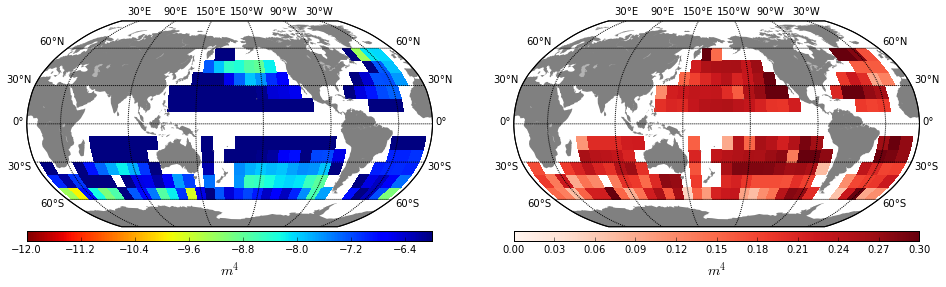

In [34]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slope_year_small), cmap='jet_r')
pc.set_clim([-12.,-6.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Error_slope_year_small), cmap='Reds')
pc.set_clim([0.,.3])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

plt.savefig('KE_annualslope_smallestscale.png', bbox_inches='tight')

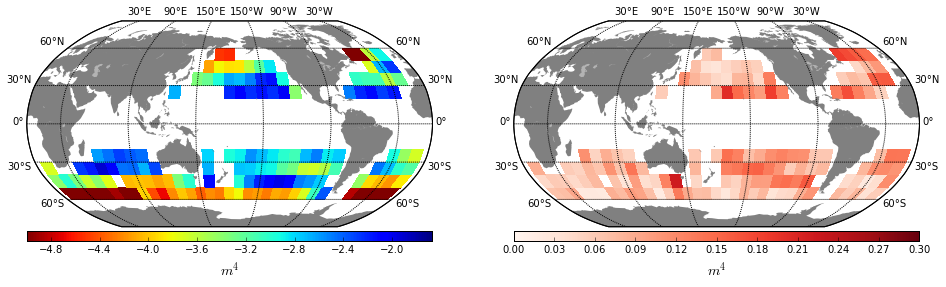

In [23]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slope_year_middle), cmap='jet_r')
pc.set_clim([-5.,-5./3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Error_slope_year_middle), cmap='Reds')
pc.set_clim([0.,.3])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

plt.savefig('KE_annualslope_middlescale.png', bbox_inches='tight')

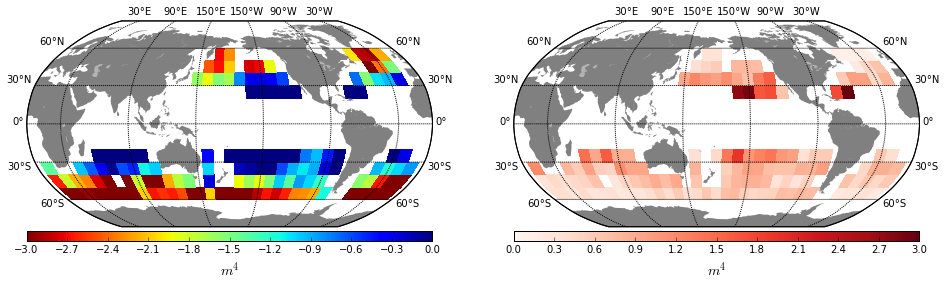

In [25]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slope_year_large), cmap='jet_r')
pc.set_clim([-3.,0.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Error_slope_year_large), cmap='Reds')
pc.set_clim([0.,3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

plt.savefig('KE_annualslope_largestscale.png', bbox_inches='tight')

In [27]:
npzfile = np.load('POP_KE_Winter_Polyfit_RossbyRadii.npz')
print npzfile.files
Slope_win_small = npzfile['Slopes_0to03Radii']
Slope_win_middle = npzfile['Slopes_03to1Radii']
Slope_win_large = npzfile['Slopes_1to2Radii']
Level_win_small = npzfile['Level_0to03Radii']
Level_win_middle = npzfile['Level_03to1Radii']
Level_win_large = npzfile['Level_1to2Radii']
Error_slope_win_small = npzfile['SlopeError_0to03Radii']
Error_slope_win_middle = npzfile['SlopeError_03to1Radii']
Error_slope_win_year_large = npzfile['SlopeError_1to2Radii']
Error_level_win_year_small = npzfile['LevelError_0to03Radii']
Error_level_win_year_middle = npzfile['LevelError_03to1Radii']
Error_level_win_year_large = npzfile['LevelError_1to2Radii']

npzfile = np.load('POP_KE_Summer_Polyfit_RossbyRadii.npz')
print npzfile.files
Slope_sum_small = npzfile['Slopes_0to03Radii']
Slope_sum_middle = npzfile['Slopes_03to1Radii']
Slope_sum_large = npzfile['Slopes_1to2Radii']
Level_sum_small = npzfile['Level_0to03Radii']
Level_sum_middle = npzfile['Level_03to1Radii']
Level_sum_large = npzfile['Level_1to2Radii']
Error_slope_sum_small = npzfile['SlopeError_0to03Radii']
Error_slope_sum_middle = npzfile['SlopeError_03to1Radii']
Error_slope_sum_large = npzfile['SlopeError_1to2Radii']
Error_level_sum_small = npzfile['LevelError_0to03Radii']
Error_level_sum_middle = npzfile['LevelError_03to1Radii']
Error_level_sum_large = npzfile['LevelError_1to2Radii']

['Fit_0to03Radii', 'Fit_03to1Radii', 'Level_0to03Radii', 'SlopeError_1to2Radii', 'Fit_1to2Radii', 'SlopeError_03to1Radii', 'SlopeError_0to03Radii', 'Level_1to2Radii', 'LevelError_0to03Radii', 'LevelError_03to1Radii', 'Level_03to1Radii', 'Slopes_1to2Radii', 'LevelError_1to2Radii', 'isospec_spectra', 'Slopes_0to03Radii', 'Slopes_03to1Radii']
['Fit_0to03Radii', 'Fit_03to1Radii', 'Level_0to03Radii', 'SlopeError_1to2Radii', 'Fit_1to2Radii', 'SlopeError_03to1Radii', 'SlopeError_0to03Radii', 'Level_1to2Radii', 'LevelError_0to03Radii', 'LevelError_03to1Radii', 'Level_03to1Radii', 'Slopes_1to2Radii', 'LevelError_1to2Radii', 'isospec_spectra', 'Slopes_0to03Radii', 'Slopes_03to1Radii']


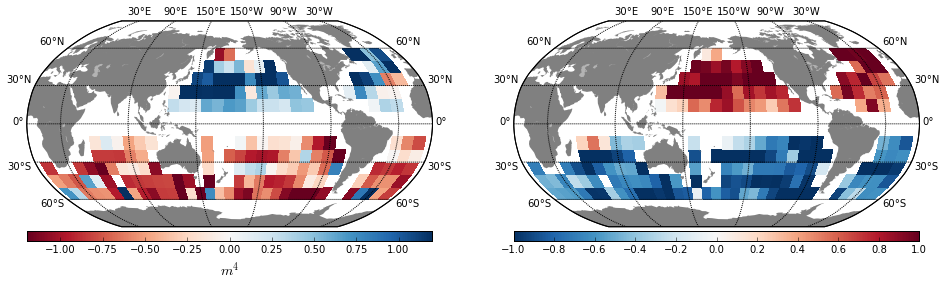

In [28]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slope_win_small - Slope_sum_small), cmap='RdBu')
pc.set_clim([-1.2,1.2])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(Level_win_small / Level_sum_small)), cmap='RdBu_r')
pc.set_clim([-1.,1.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
# cbar.set_label('$m^3$', fontsize=14)

plt.savefig('KE_seasonality_smallestscale.png', bbox_inches='tight')

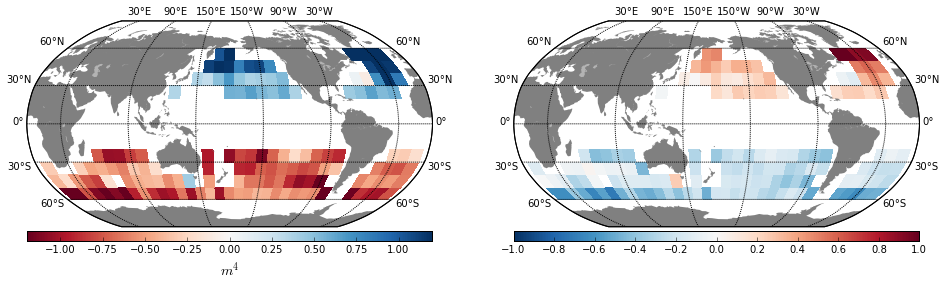

In [29]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slope_win_middle - Slope_sum_middle), cmap='RdBu')
pc.set_clim([-1.2,1.2])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(Level_win_middle / Level_sum_middle)), cmap='RdBu_r')
pc.set_clim([-1.,1.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
# cbar.set_label('$m^3$', fontsize=14)

plt.savefig('KE_seasonality_middlescale.png', bbox_inches='tight')

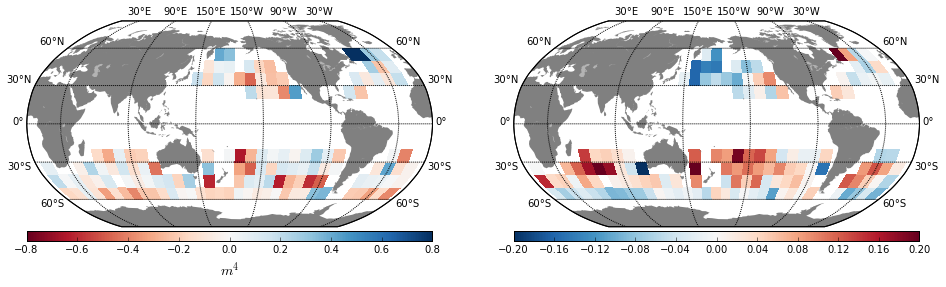

In [30]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slope_win_large - Slope_sum_large), cmap='RdBu')
pc.set_clim([-.8,.8])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(Level_win_large / Level_sum_large)), cmap='RdBu_r')
pc.set_clim([-.2,.2])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
# cbar.set_label('$m^3$', fontsize=14)

plt.savefig('KE_seasonality_largestscale.png', bbox_inches='tight')

In [31]:
alpha = 0.05
aWin, bWin = stats.chi2.ppf([1-alpha*0.5, alpha*0.5], 2*(Neff_Jan + Neff_Feb + Neff_Mar))     # 1-2*(alpha/2) = 1-alpha = p
aSum, bSum = stats.chi2.ppf([1-alpha*0.5, alpha*0.5], 2*(Neff_Jul + Neff_Aug + Neff_Sep))
print aWin, bWin, aSum, bSum

#interval_winter = 2*N_eff_winter.sum()*(1/aWin-1/bWin)
#err_winter = 2*N_eff_winter.sum()*np.array([1/aWin, 1/bWin])
#interval_winter = 2*N_eff_summer.sum()*(1/aSum-1/bSum)
#err_summer = 2*N_eff_summer.sum()*np.array([1/aSum, 1/bSum])
err_bar = 2*(Neff_Jul + Neff_Aug + Neff_Sep)*np.array([1/aSum, 1/bSum])

815.175399558 664.61247328 815.175399558 664.61247328


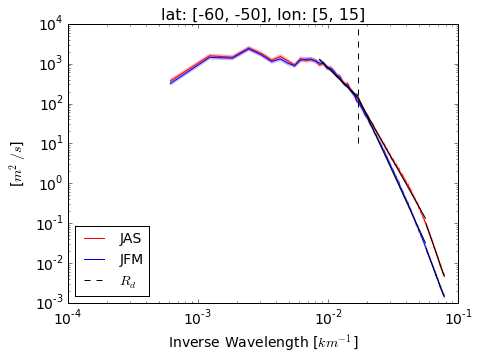

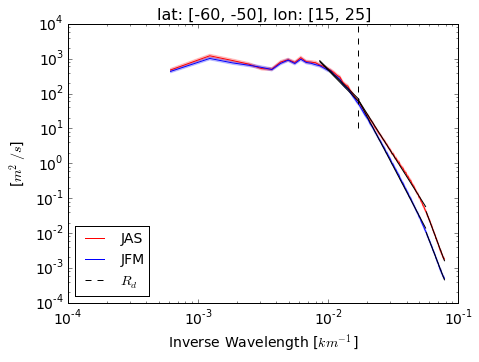

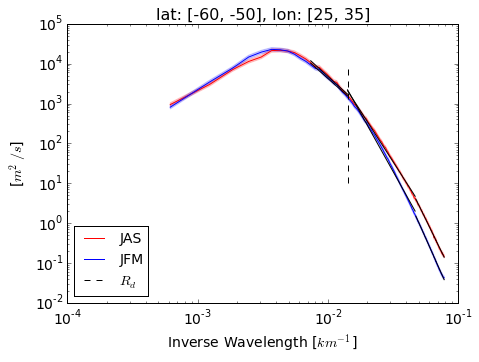

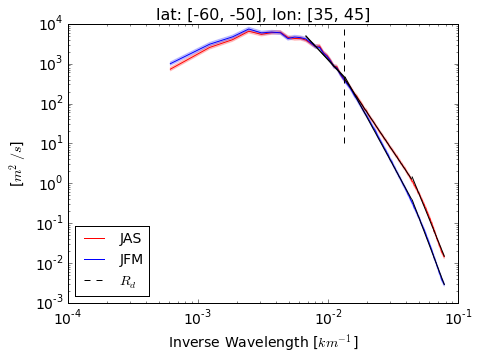

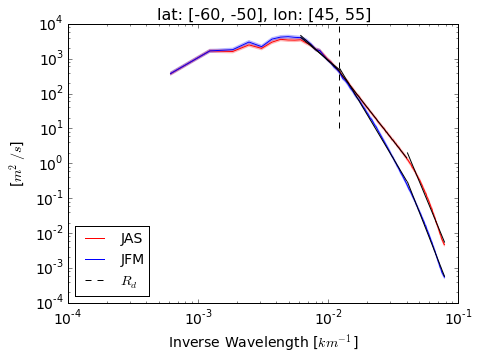

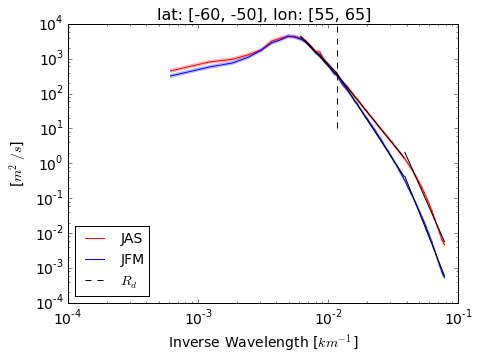

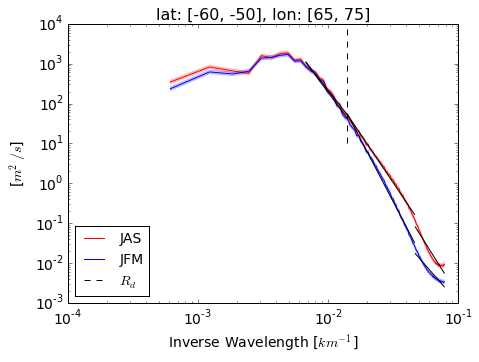

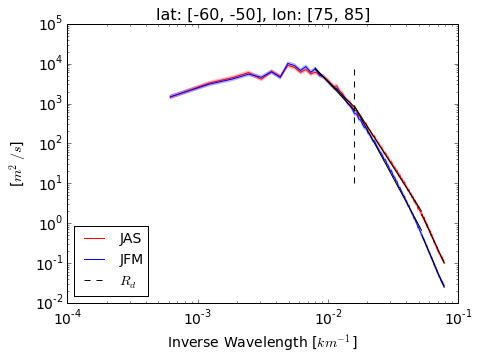

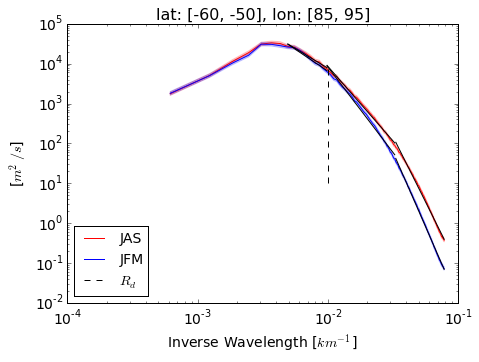

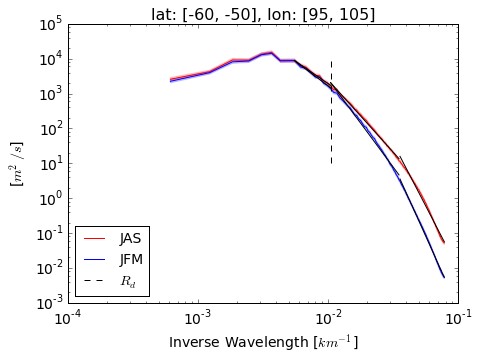

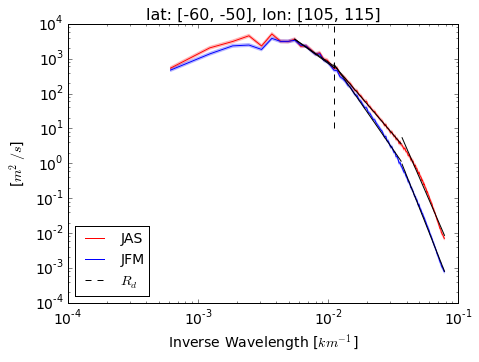

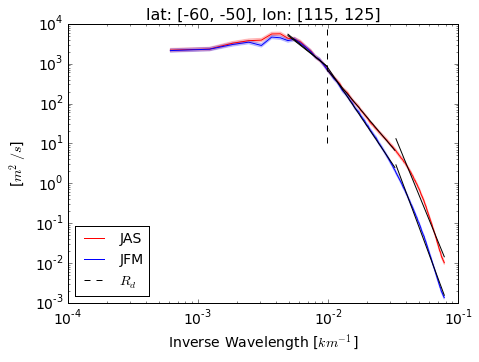

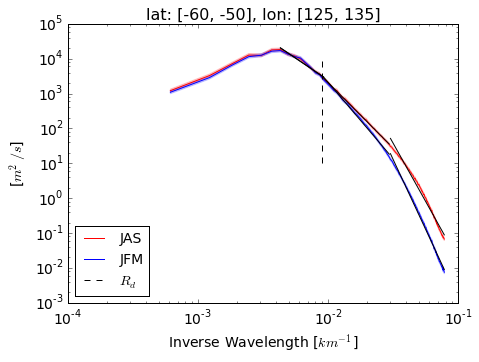

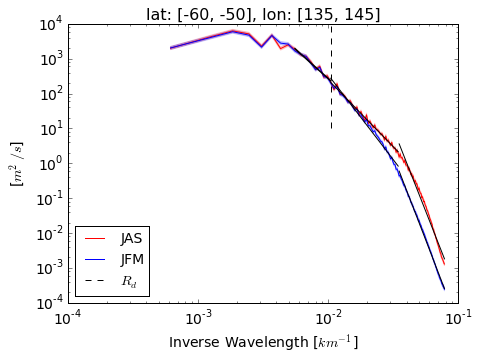

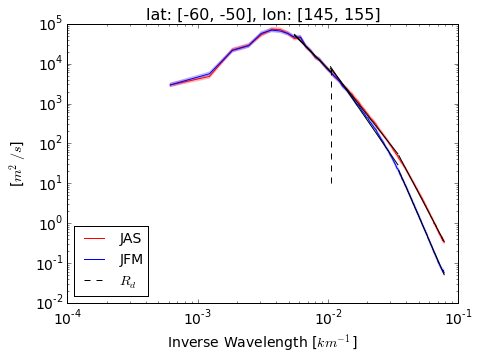

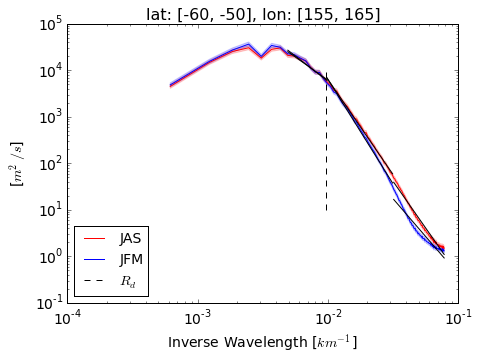

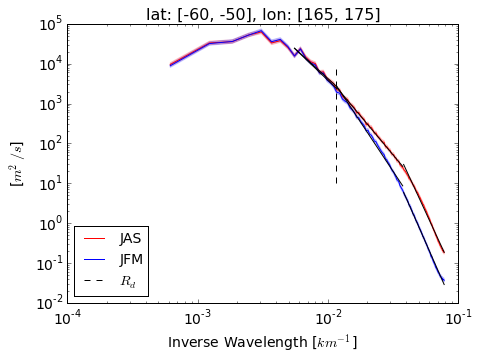

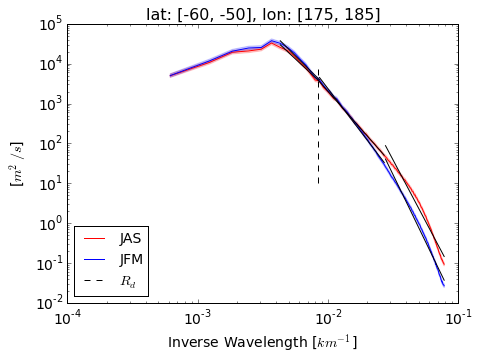

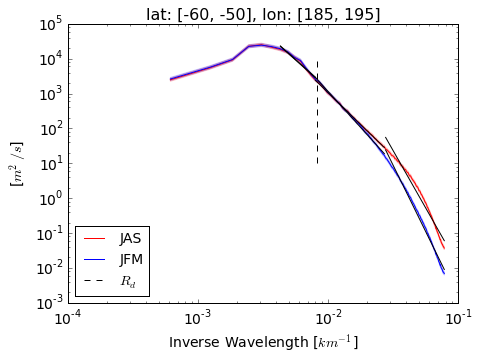

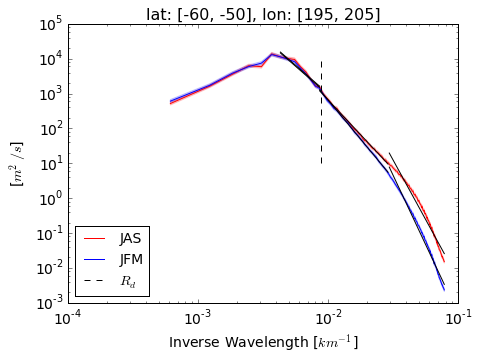

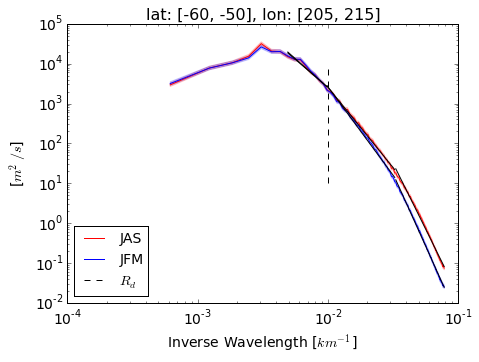

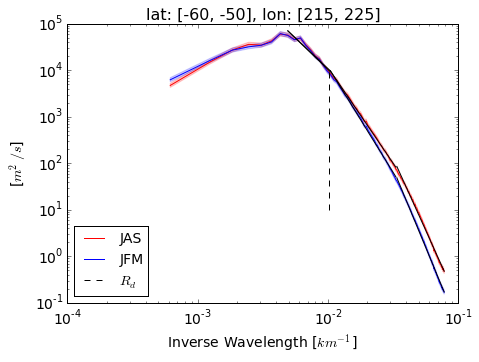

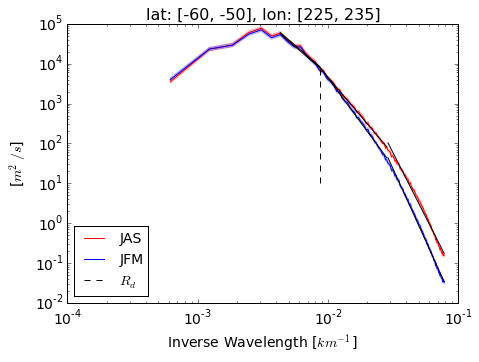

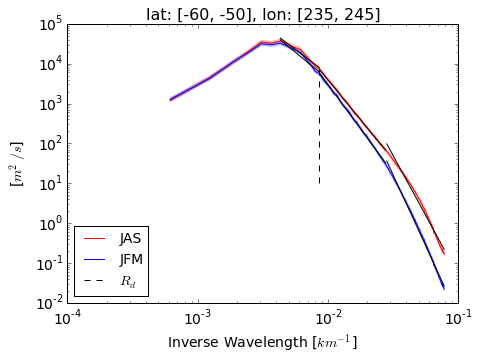

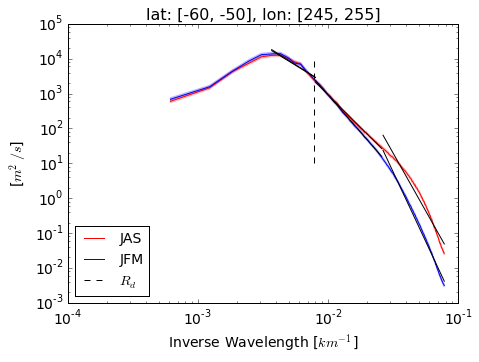

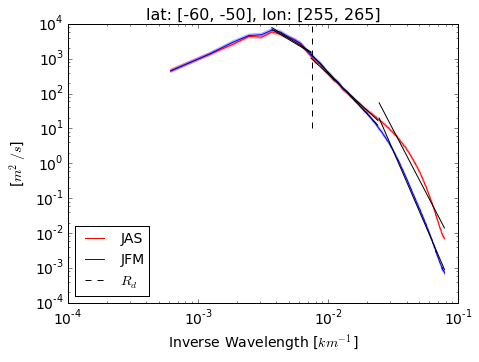

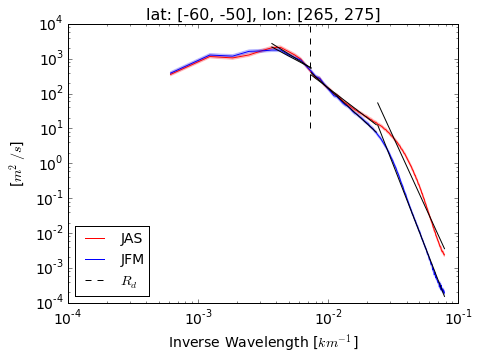

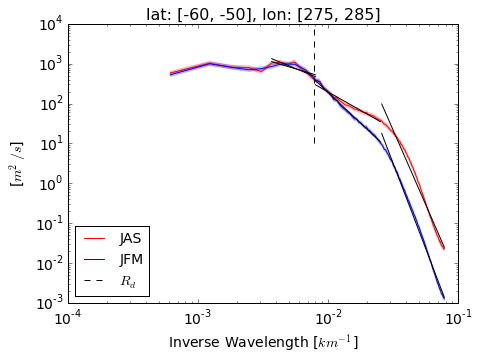

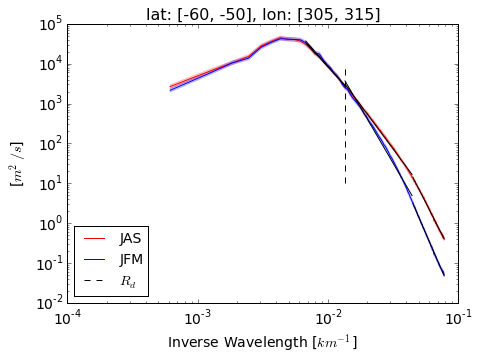

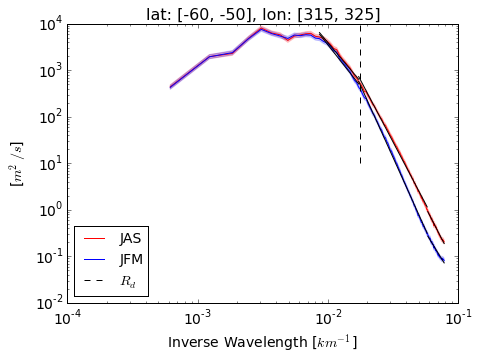

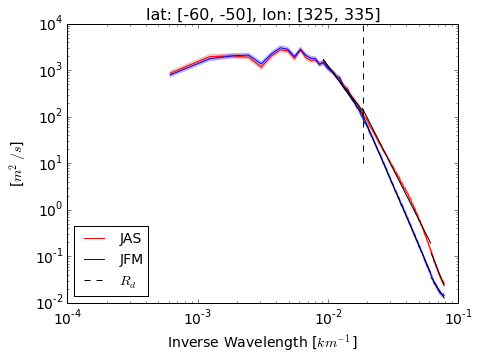

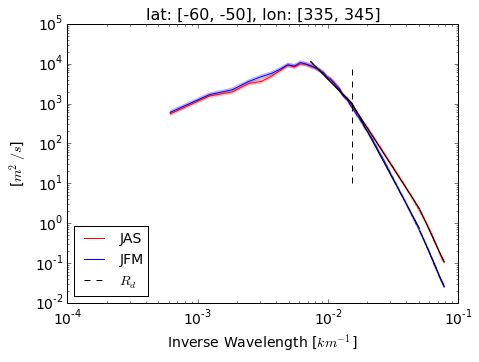

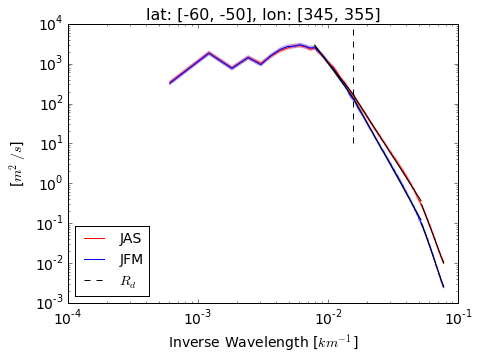

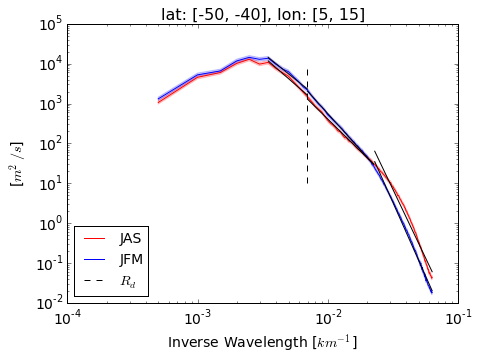

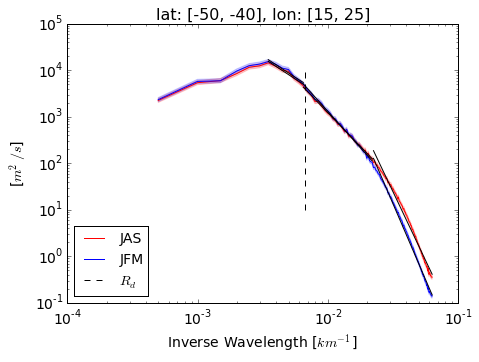

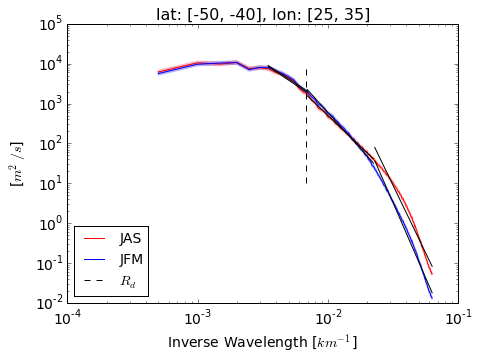

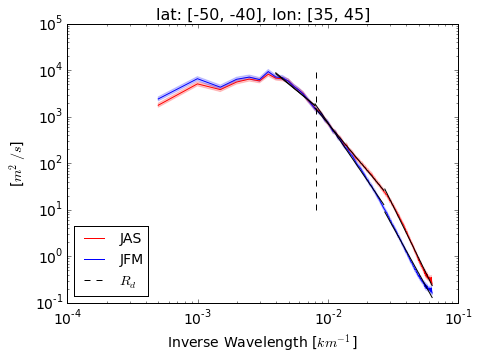

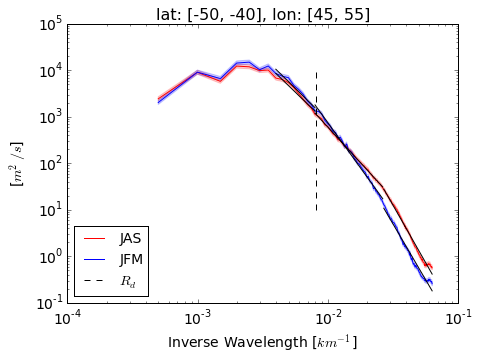

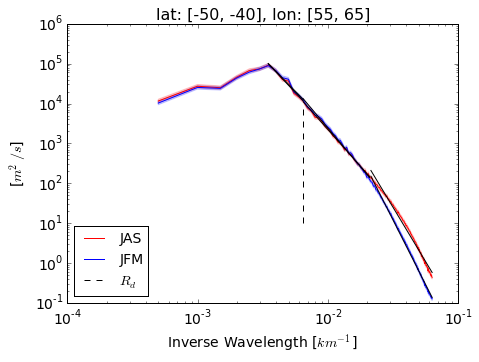

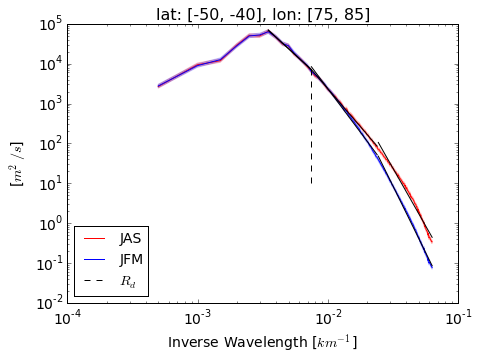

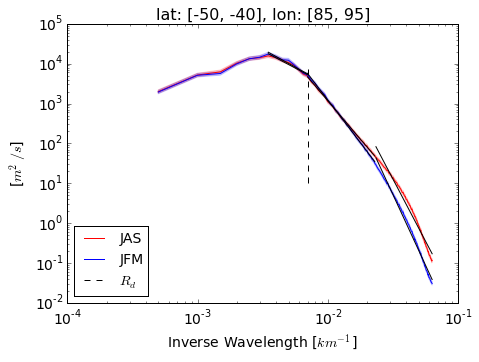

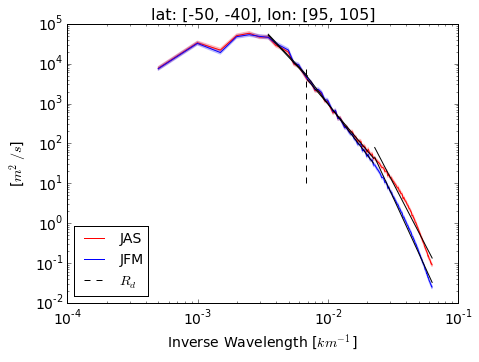

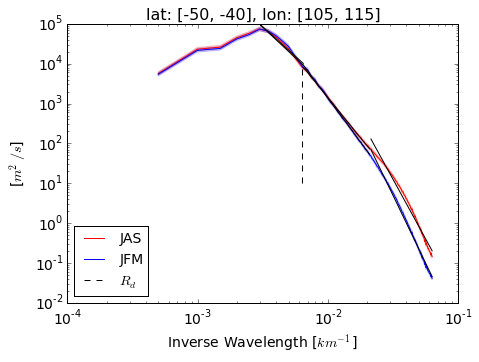

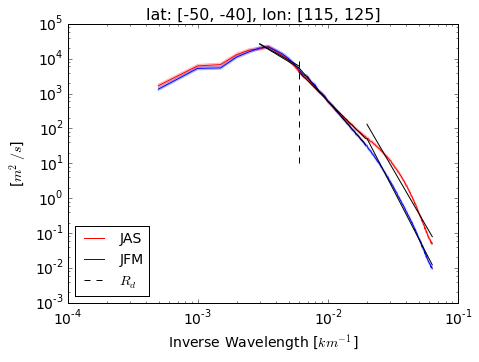

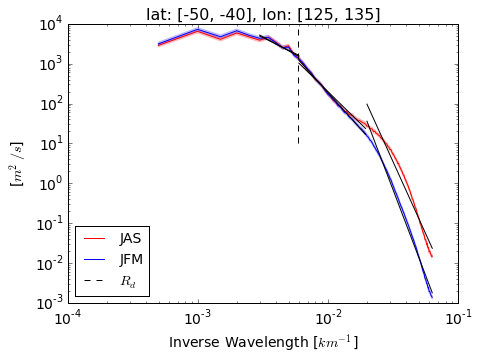

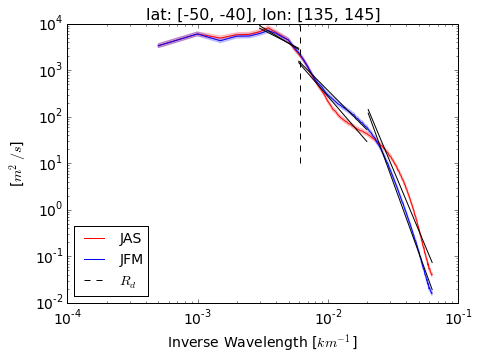

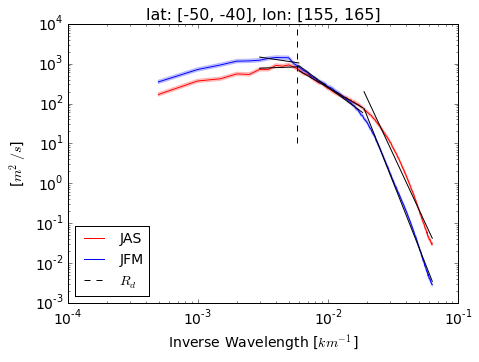

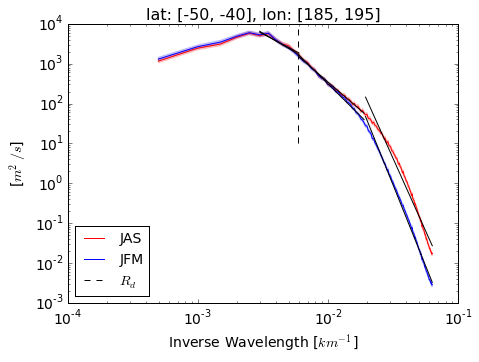

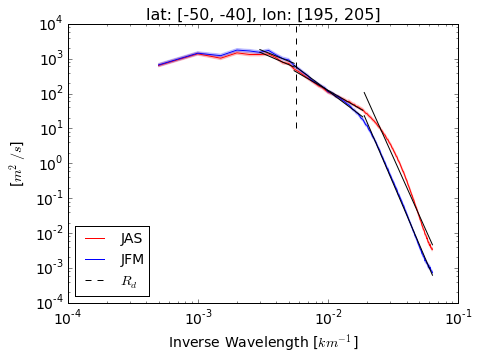

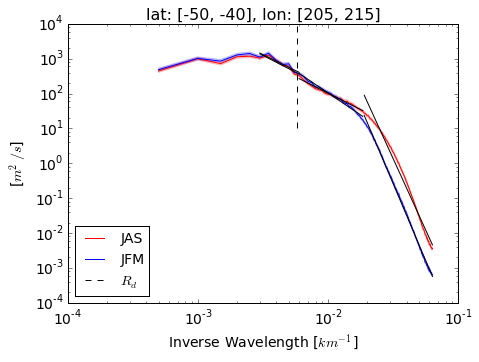

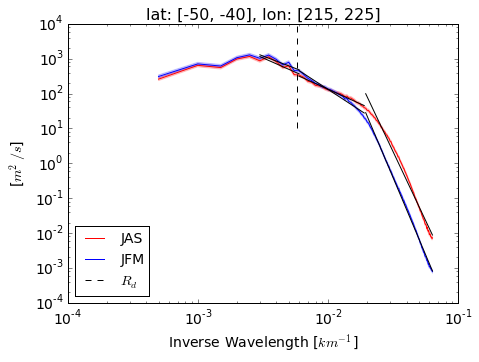

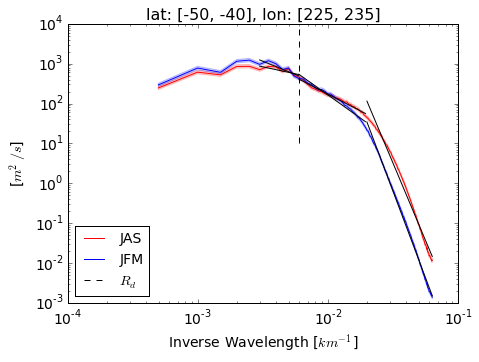

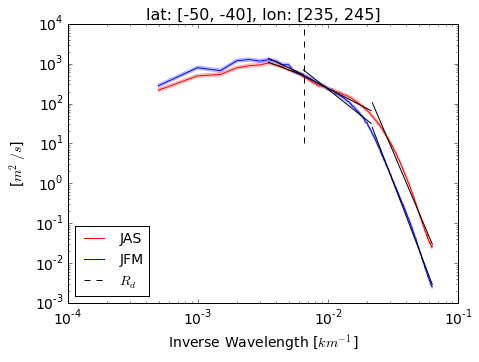

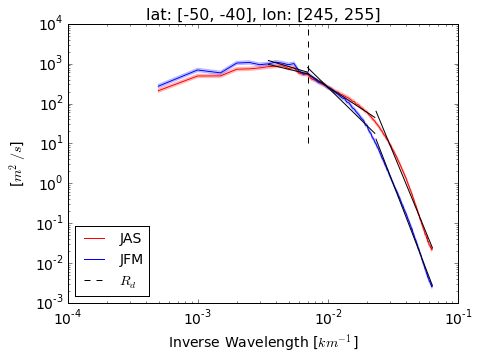

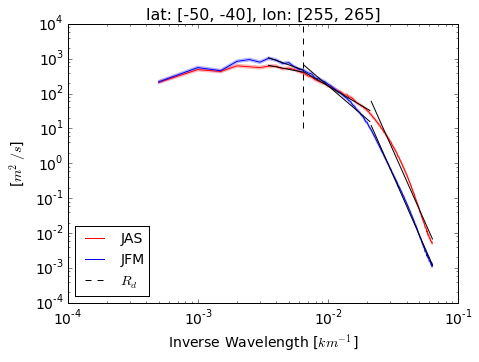

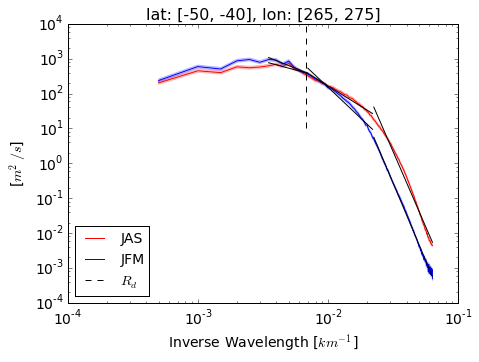

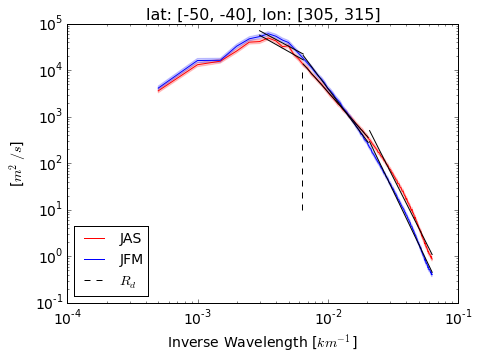

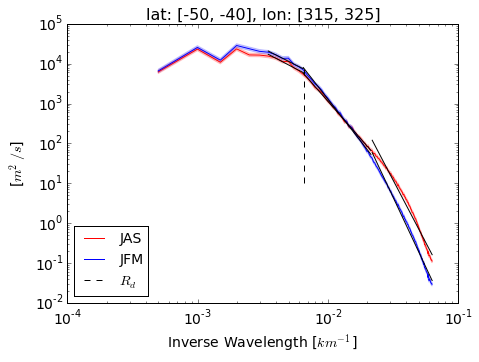

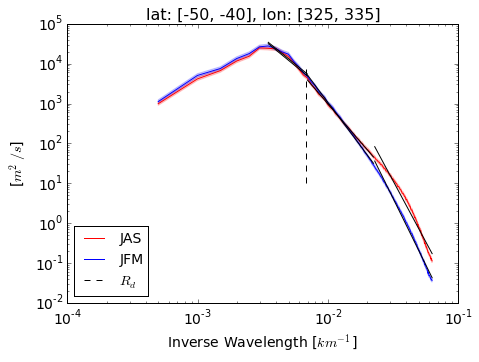

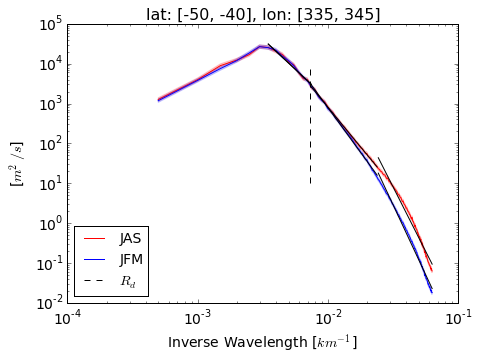

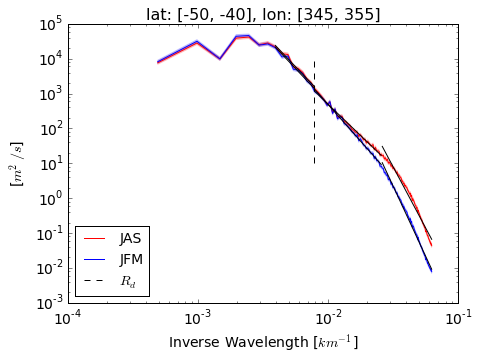

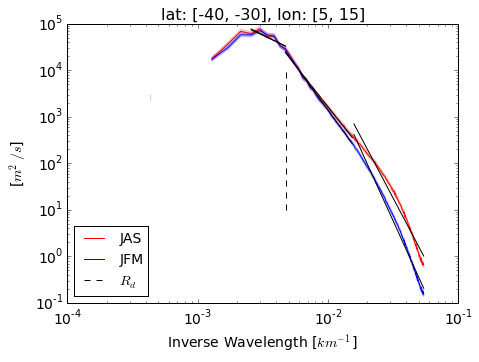

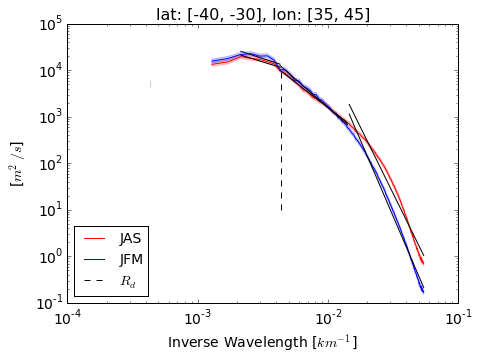

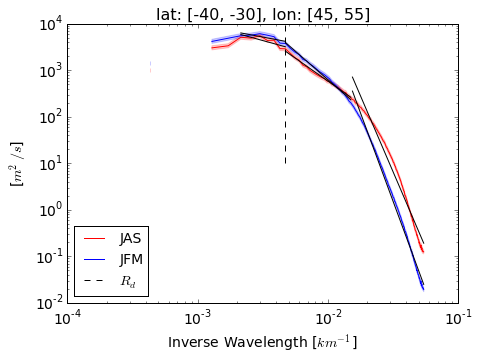

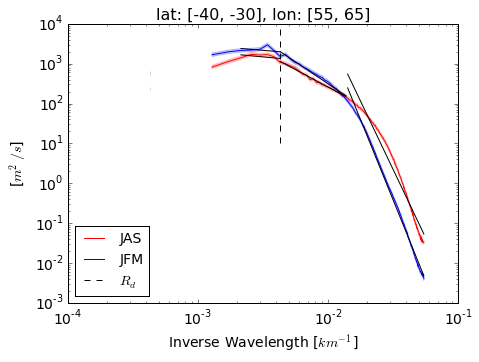

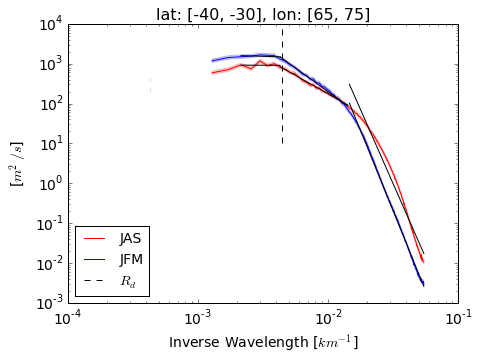

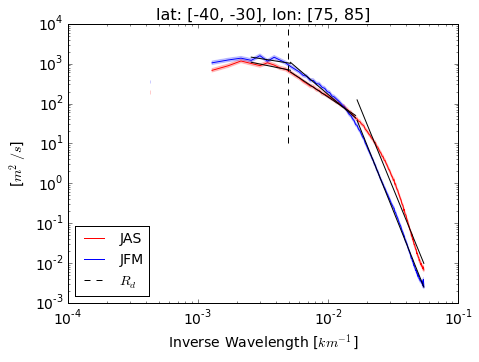

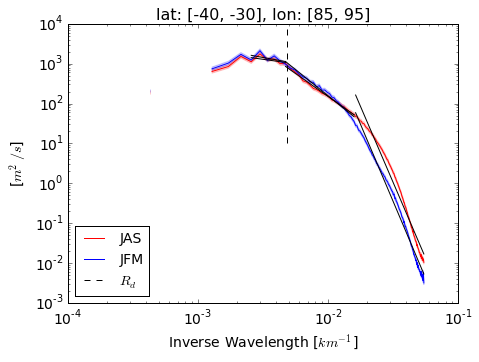

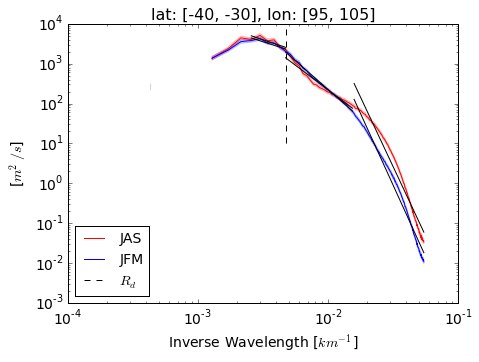

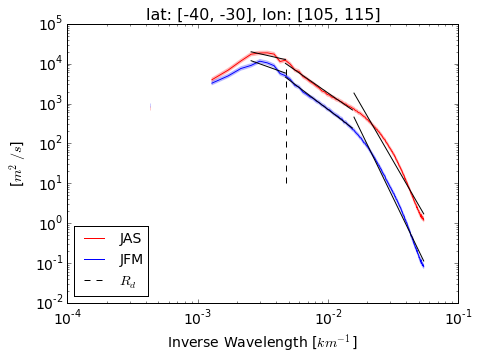

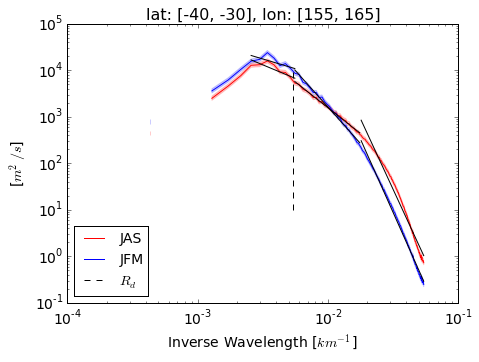

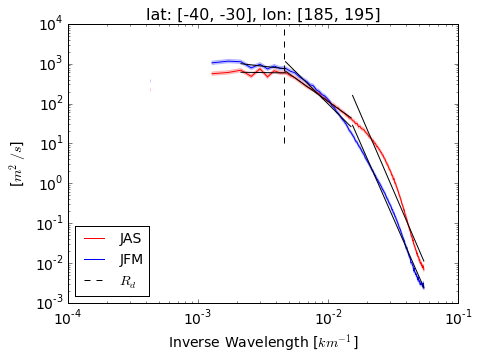

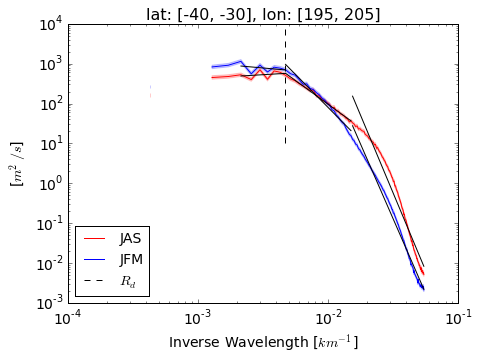

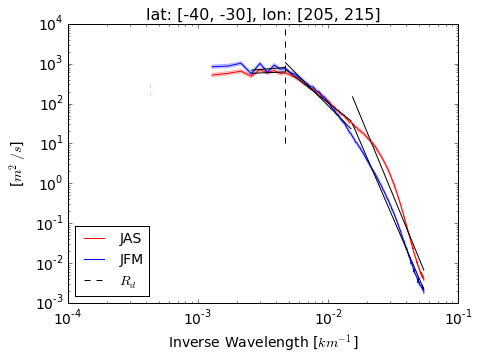

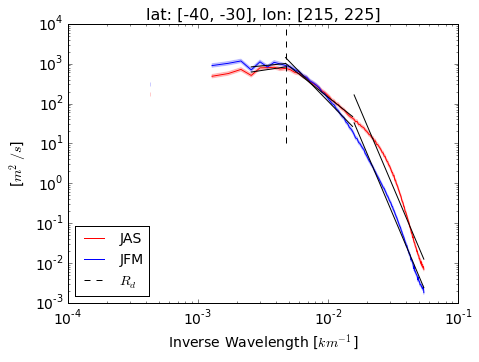

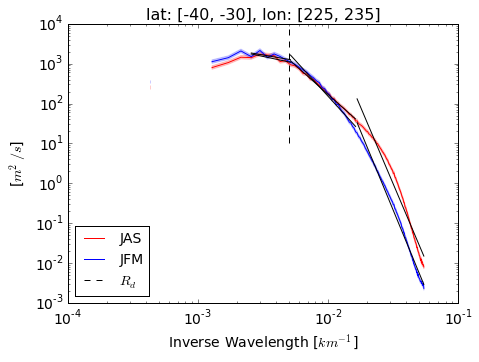

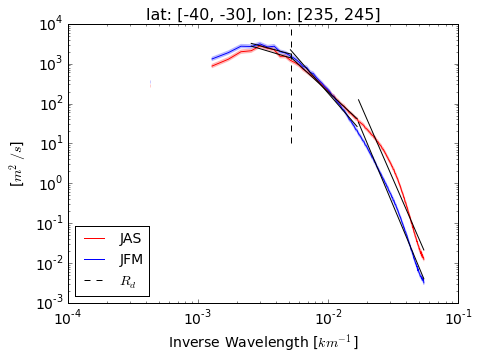

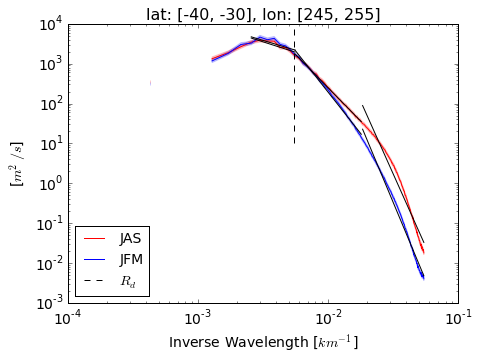

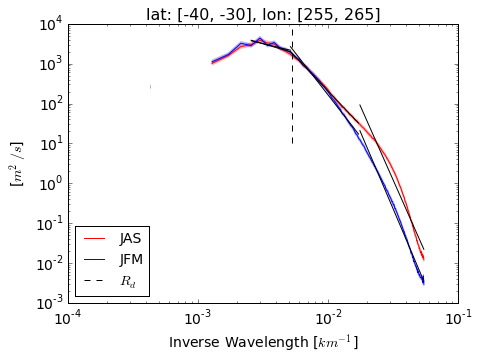

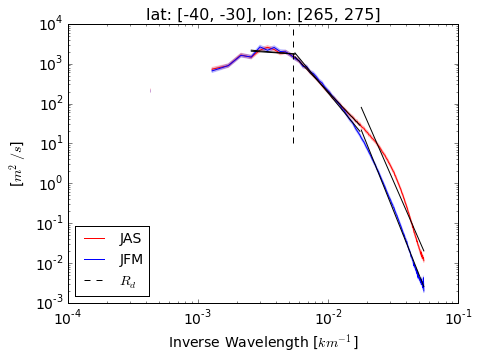

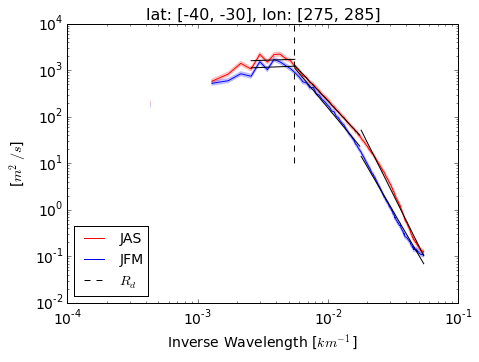

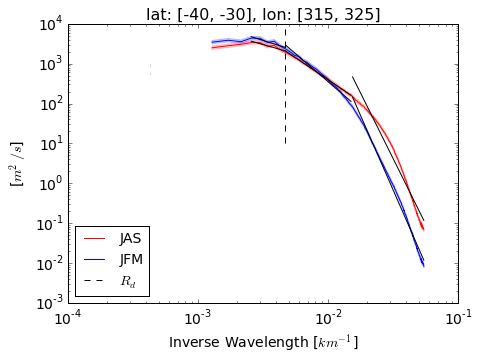

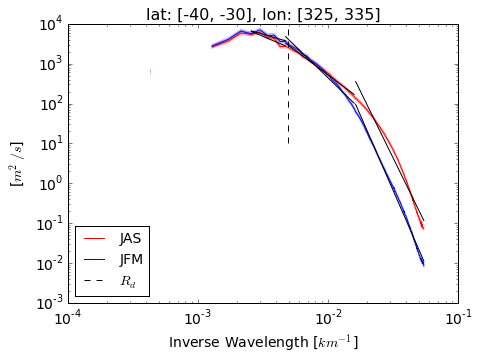

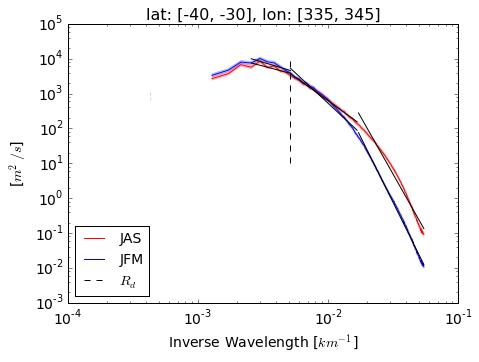

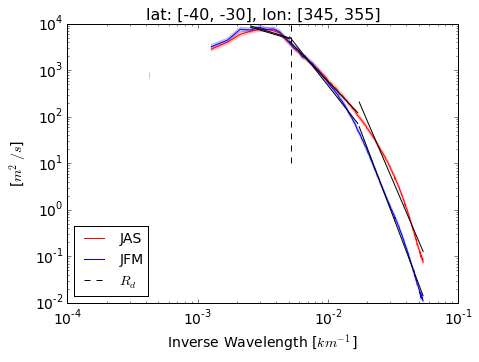

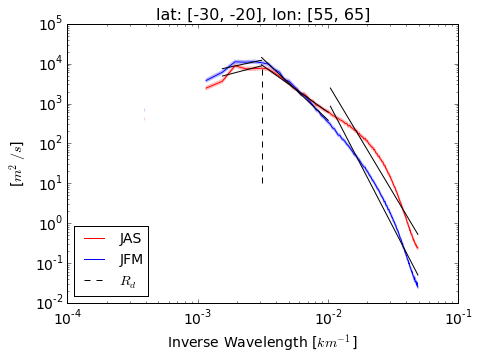

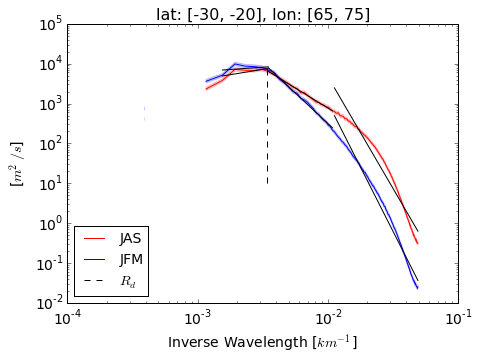

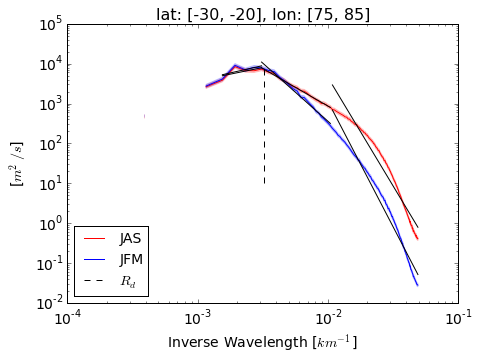

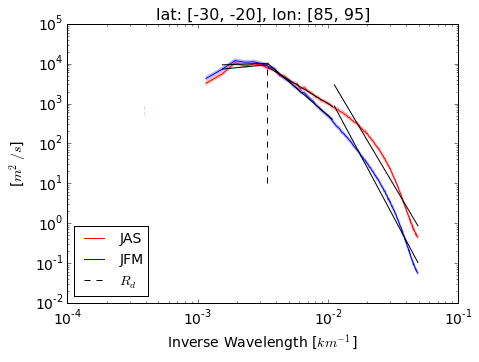

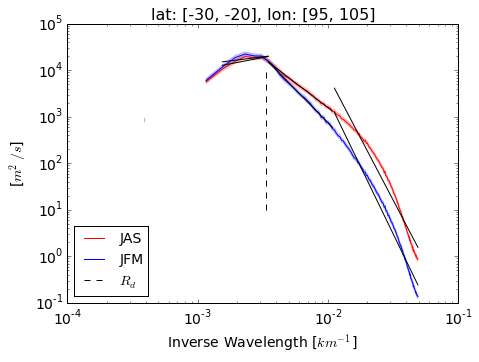

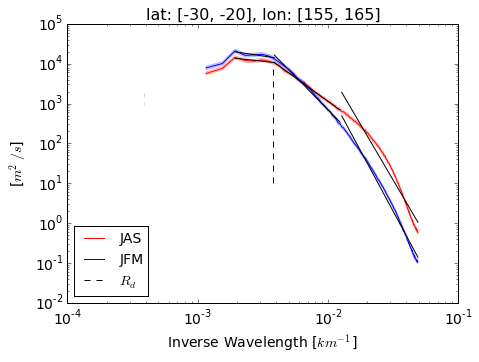

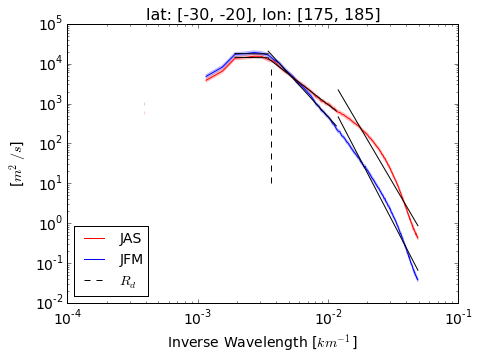

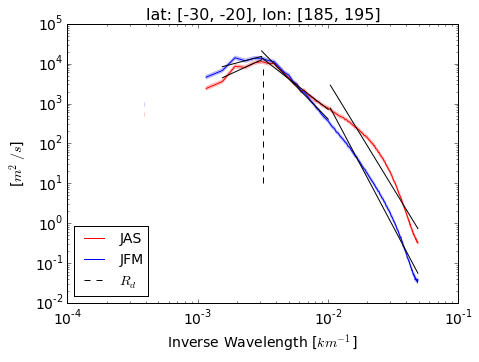

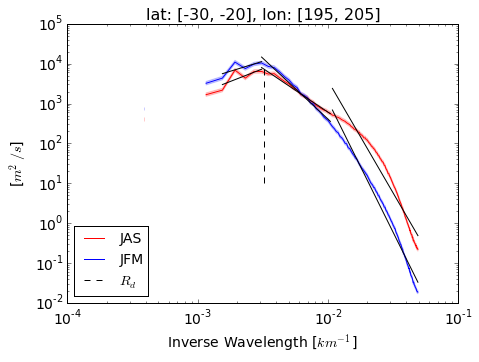

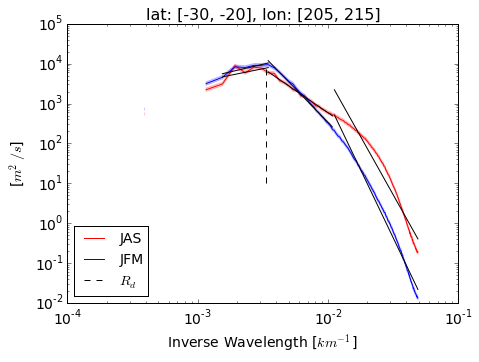

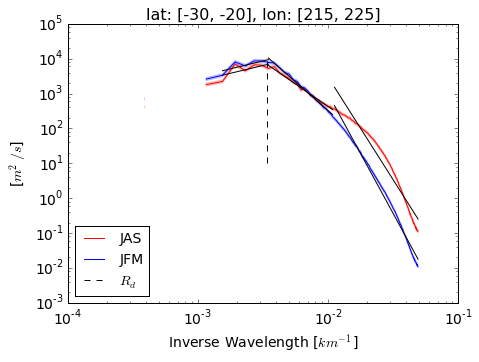

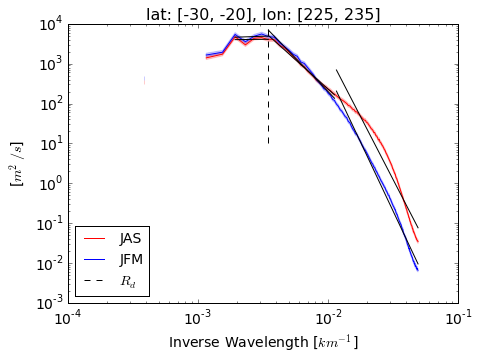

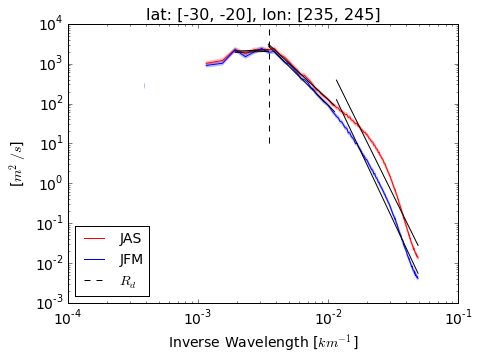

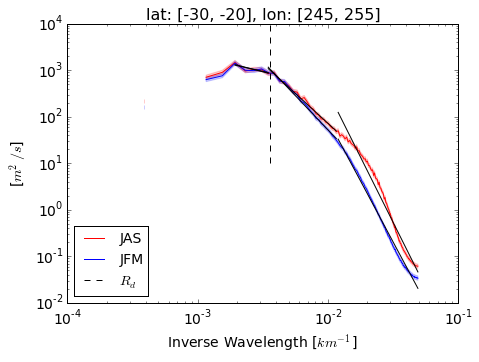

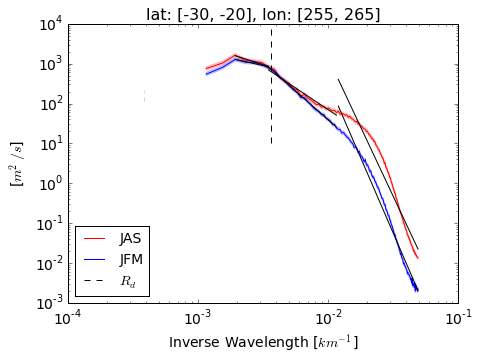

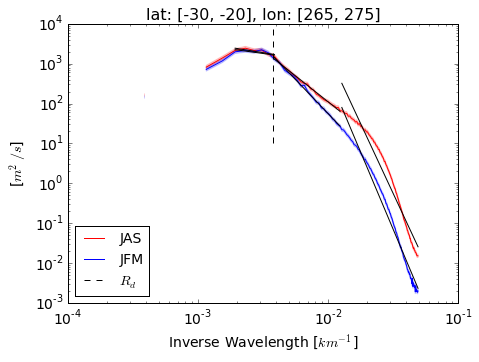

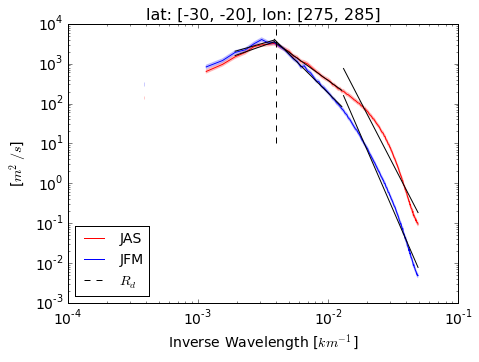

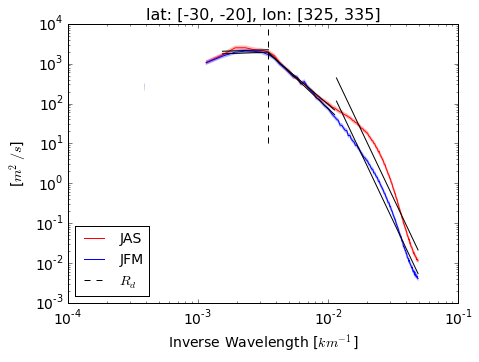

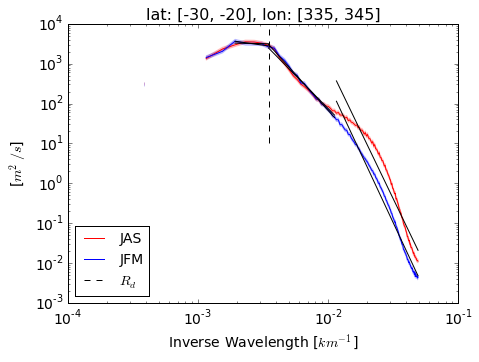

No plot of fit between 1-2 radii


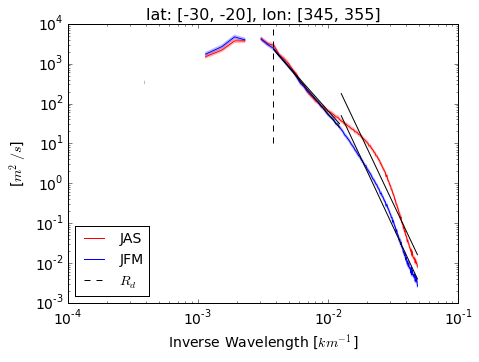

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


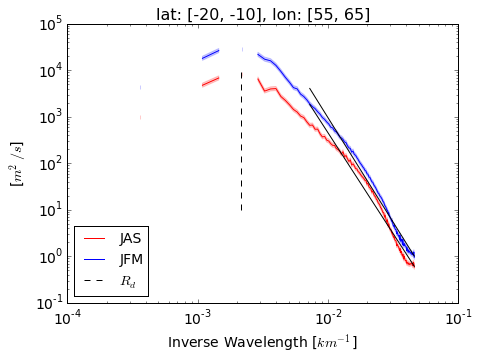

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


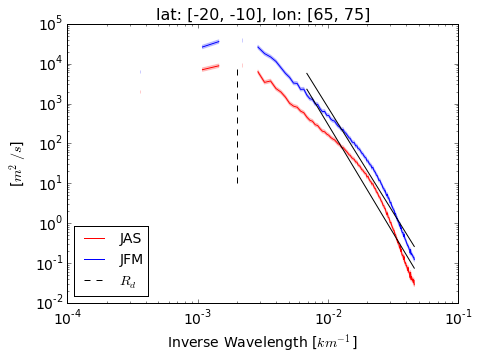

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


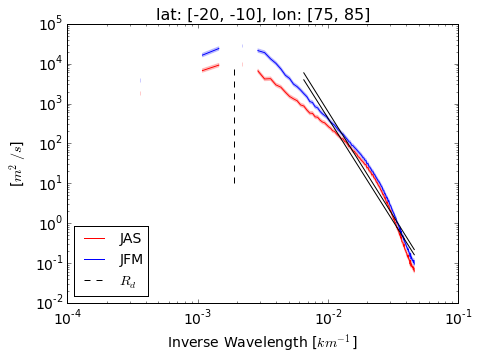

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


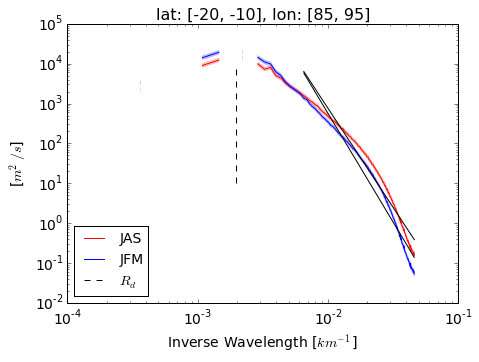

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


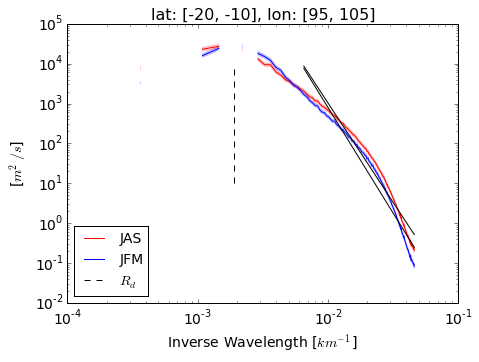

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


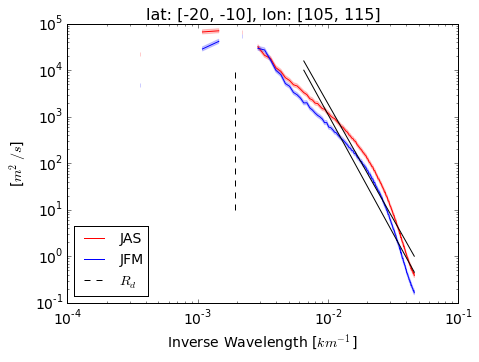

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


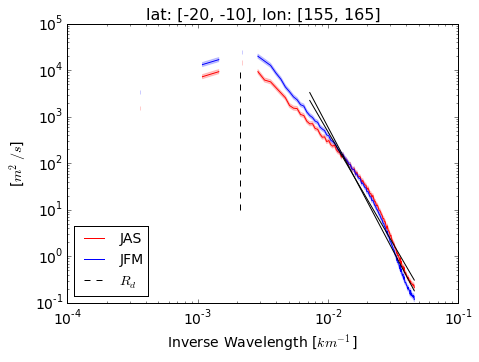

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


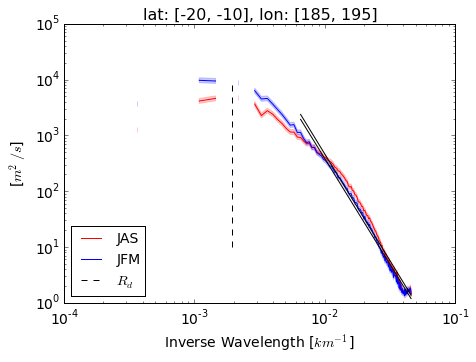

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


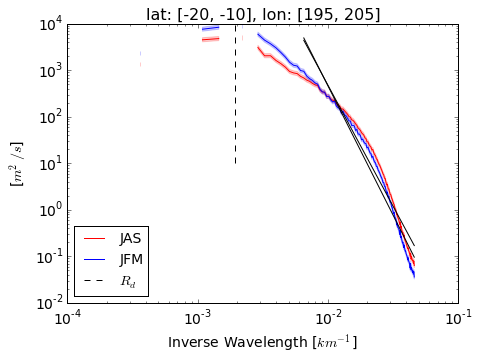

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


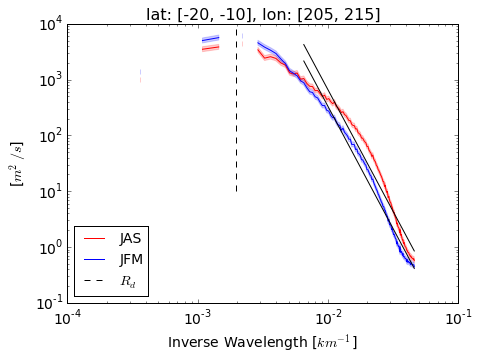

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


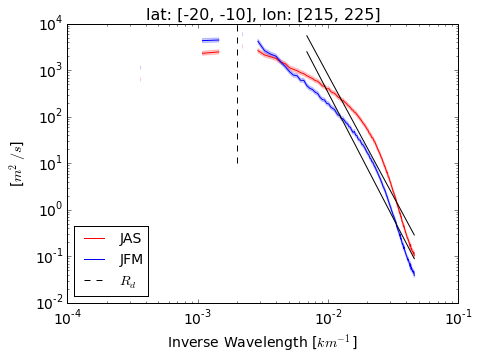

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


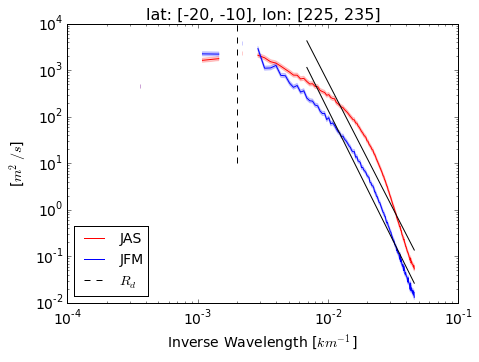

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


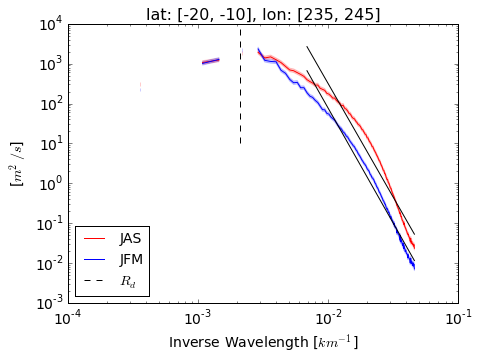

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


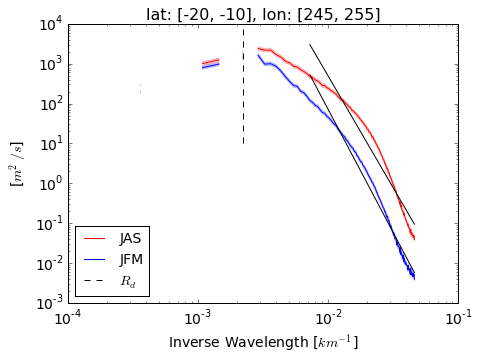

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


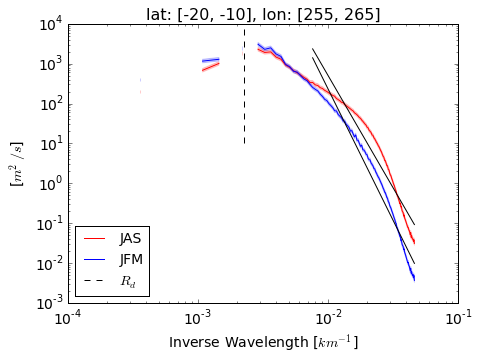

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


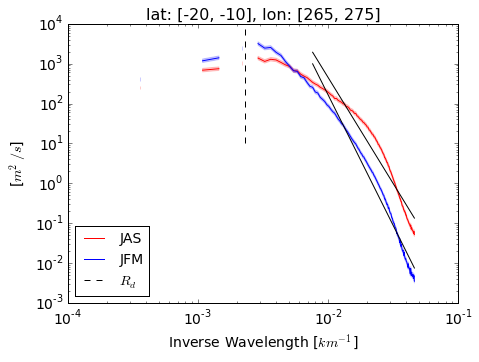

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


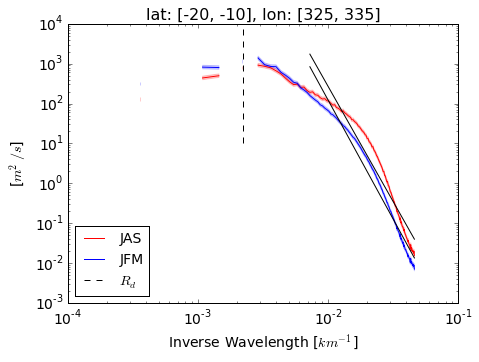

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


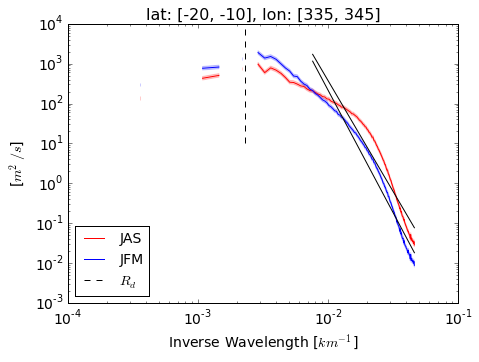

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


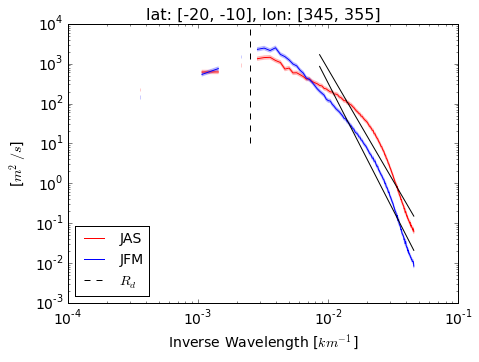

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


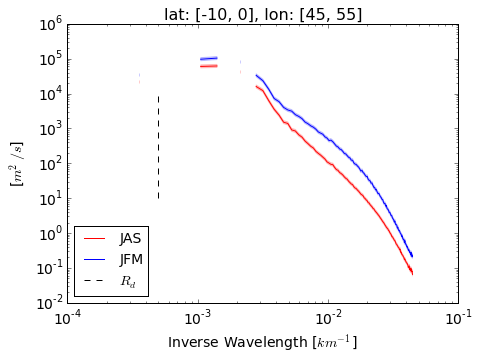

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


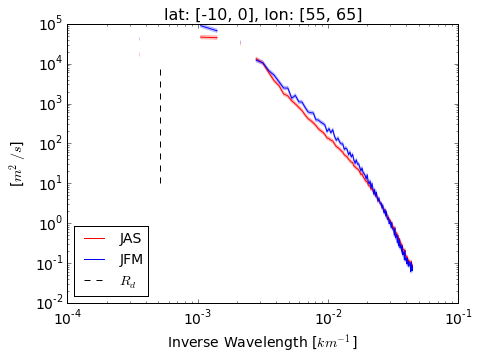

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


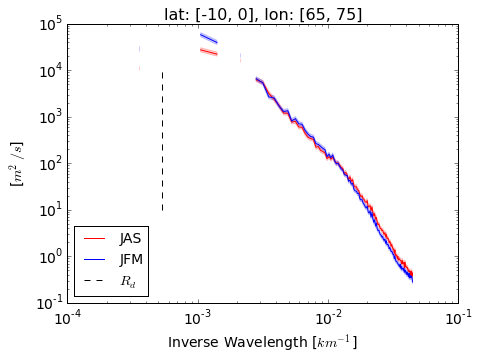

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


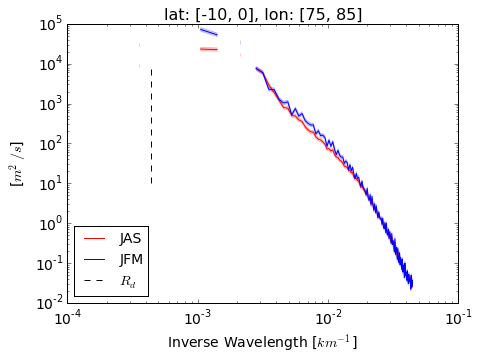

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


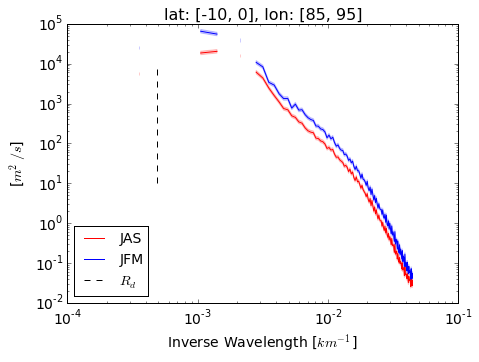

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


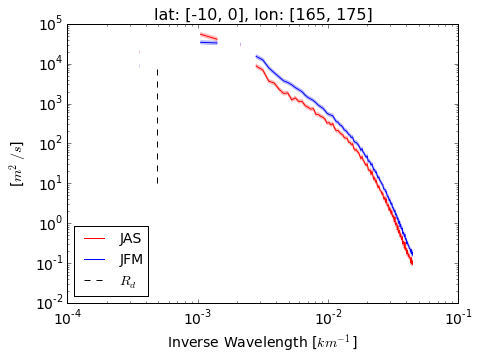

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


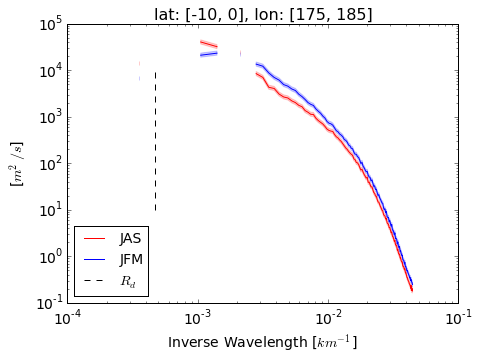

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


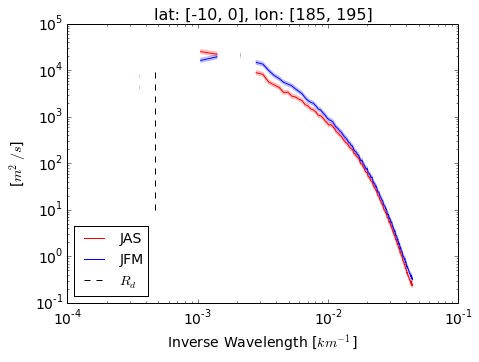

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


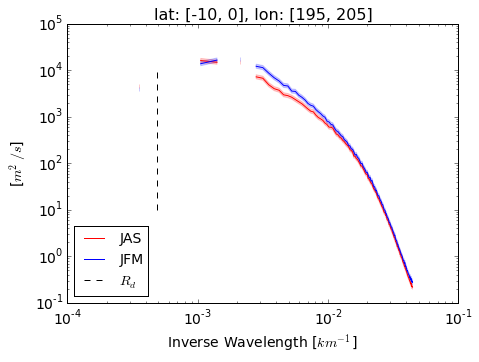

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


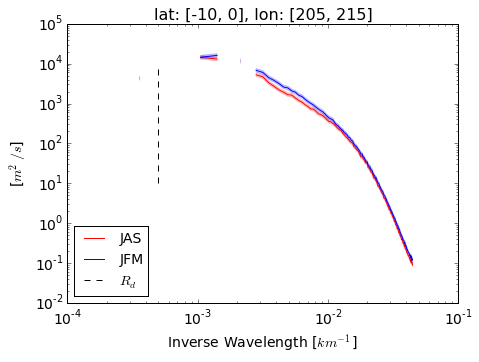

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


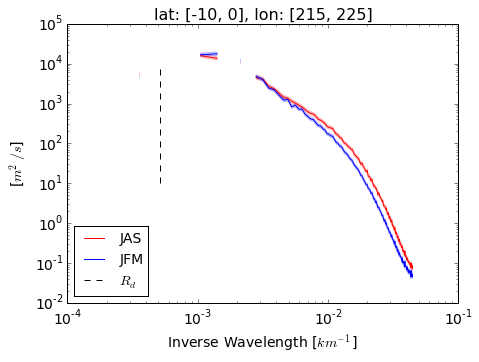

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


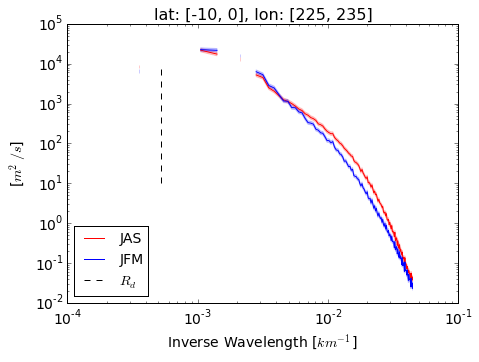

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


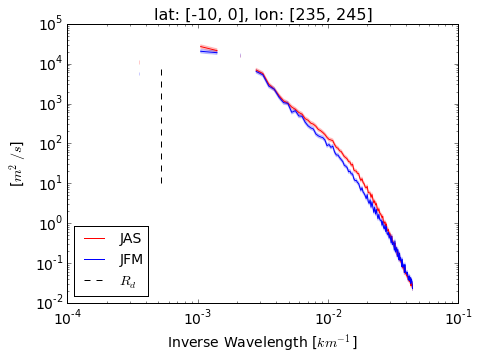

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


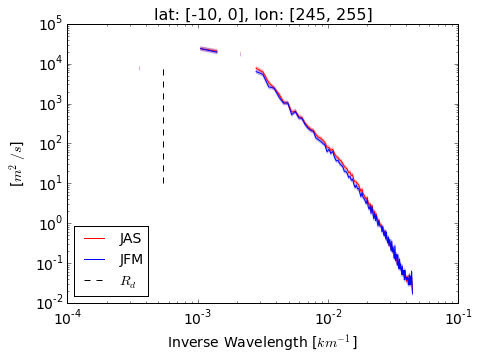

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


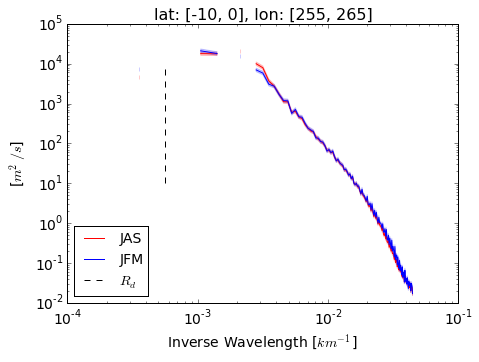

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


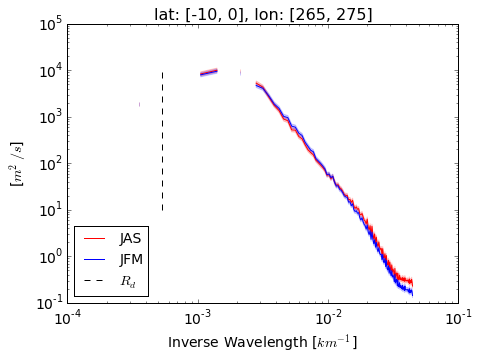

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


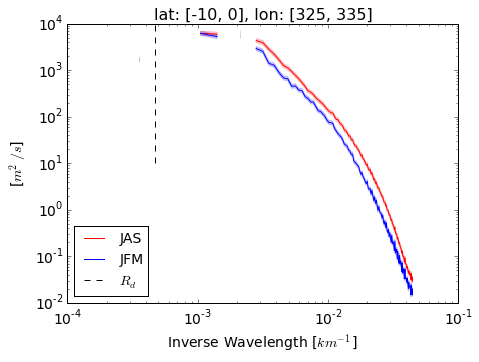

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


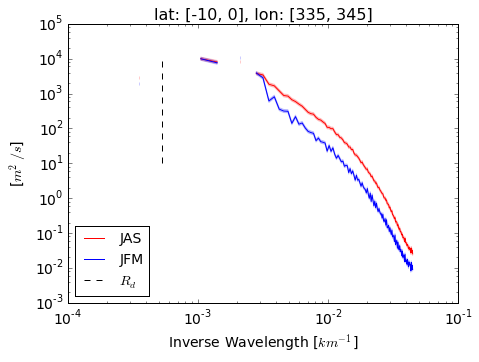

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


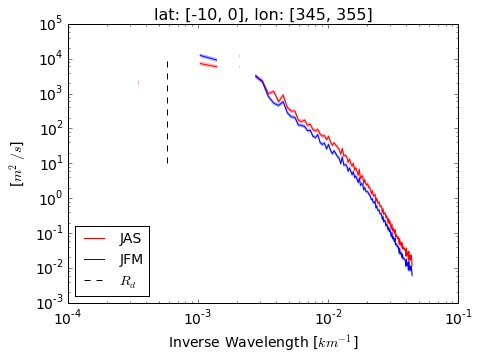

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


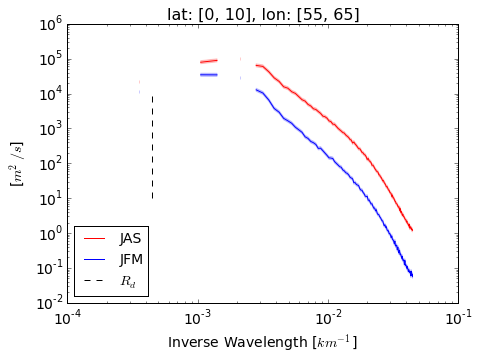

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


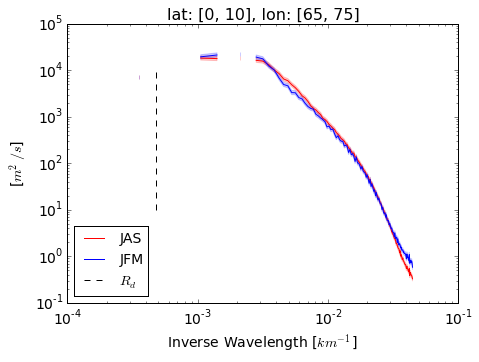

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


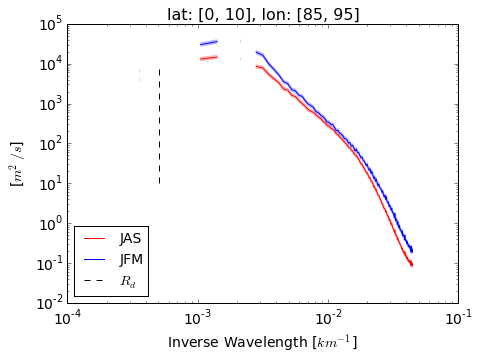

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


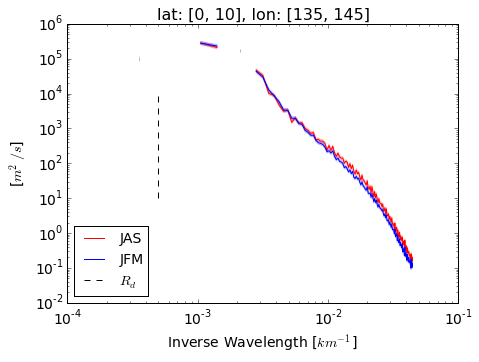

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


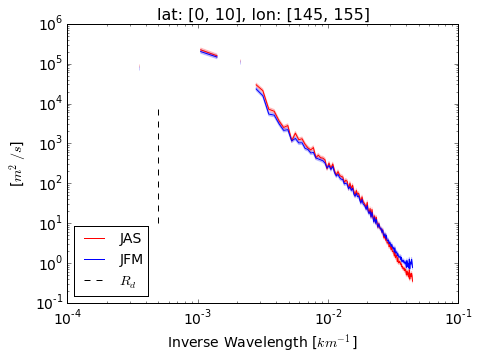

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


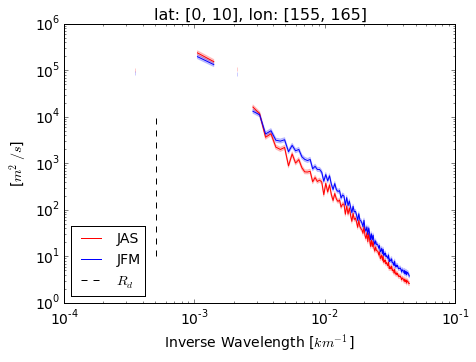

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


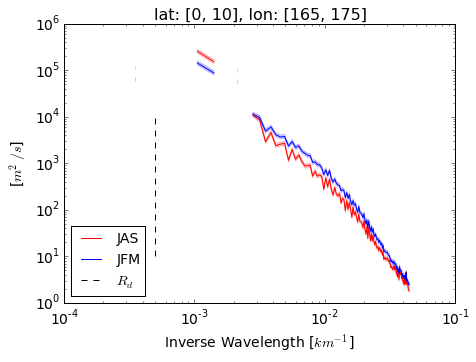

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


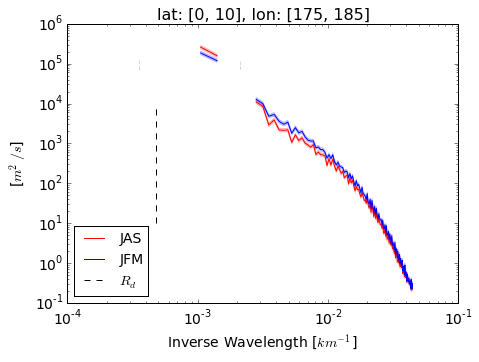

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


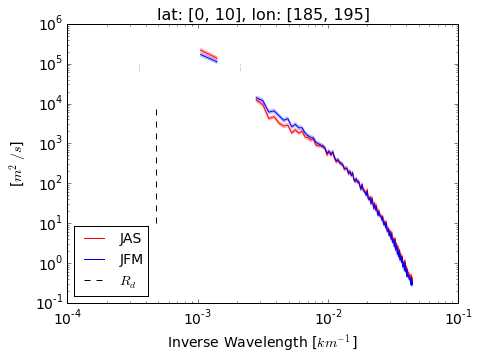

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


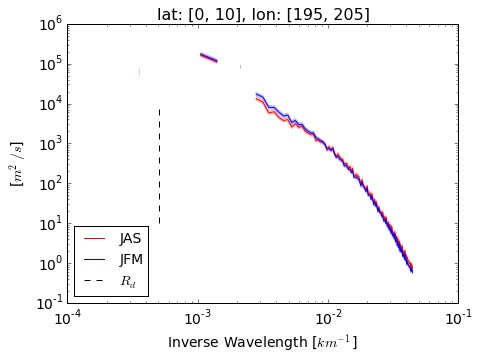

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


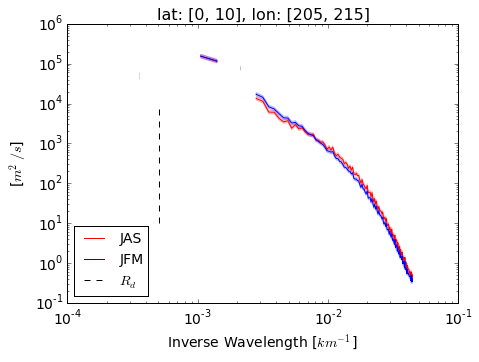

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


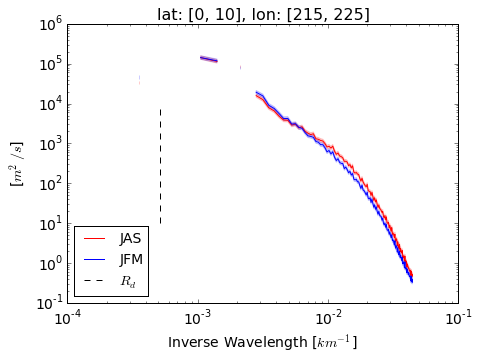

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


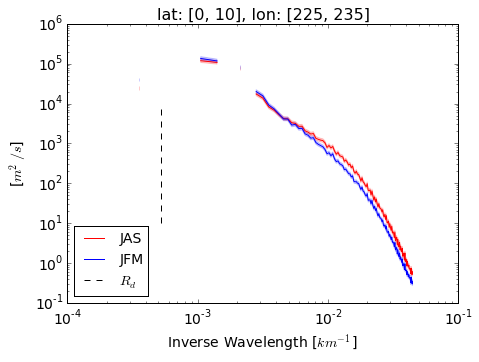

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


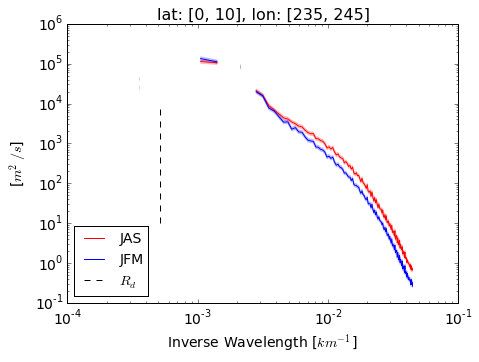

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


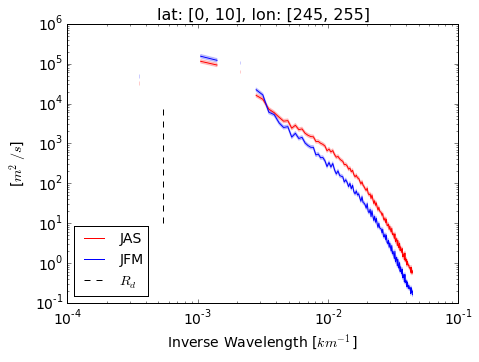

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


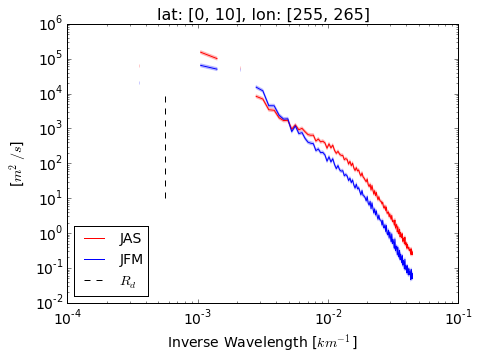

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


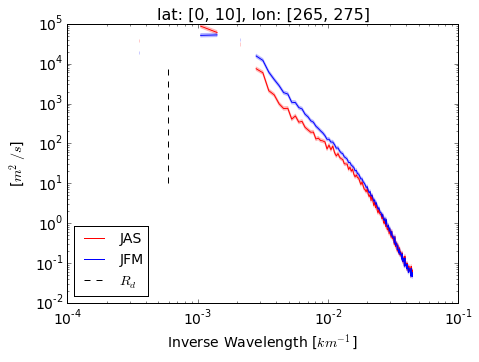

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


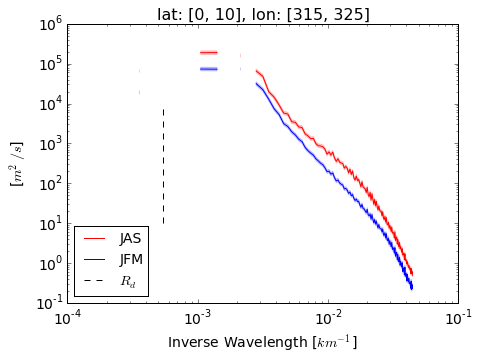

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


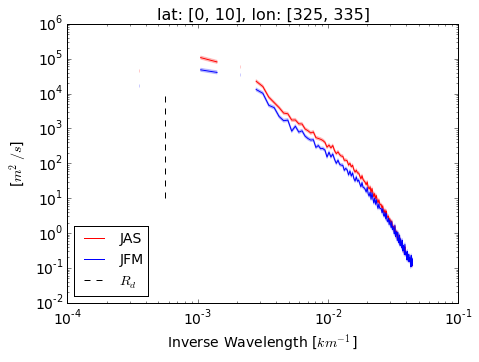

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


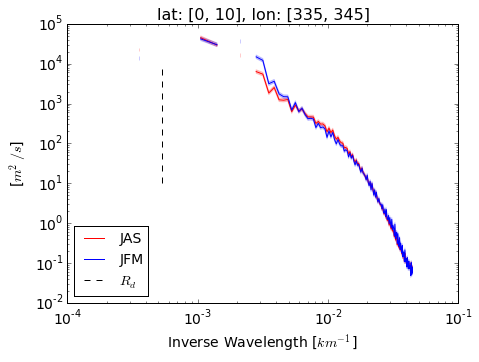

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


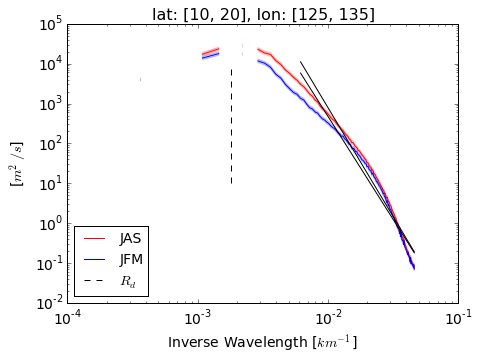

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


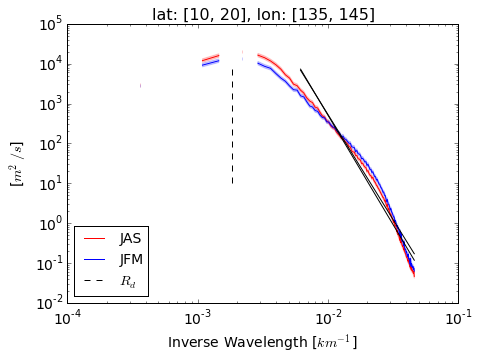

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


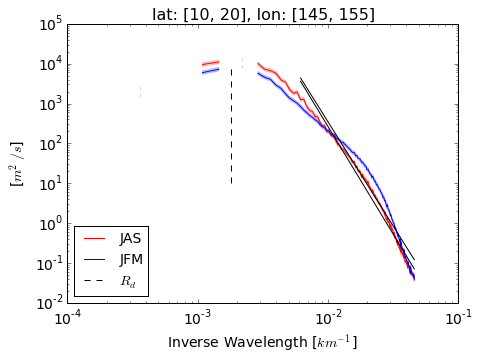

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


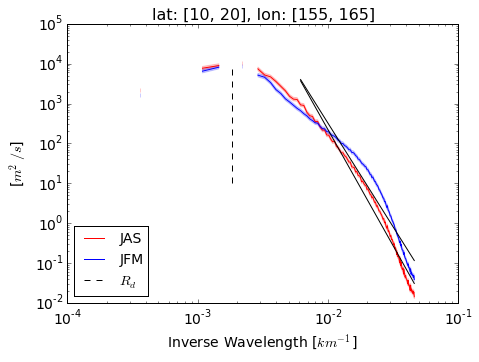

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


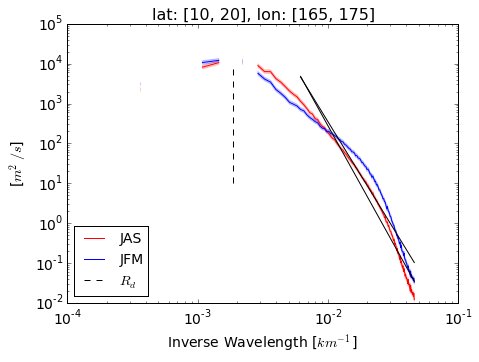

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


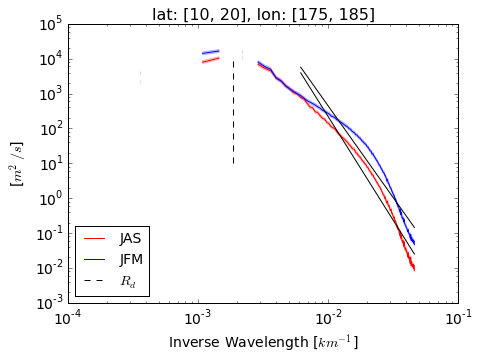

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


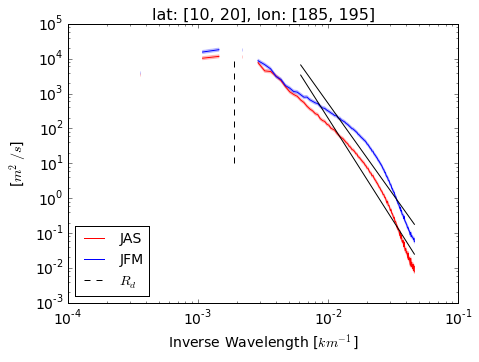

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


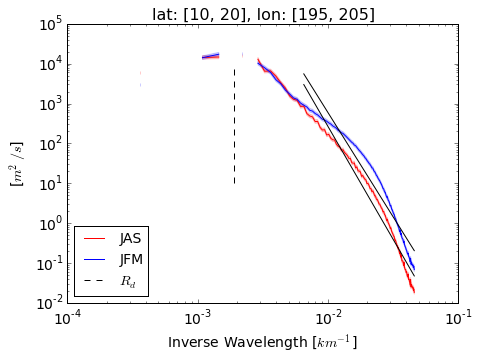

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


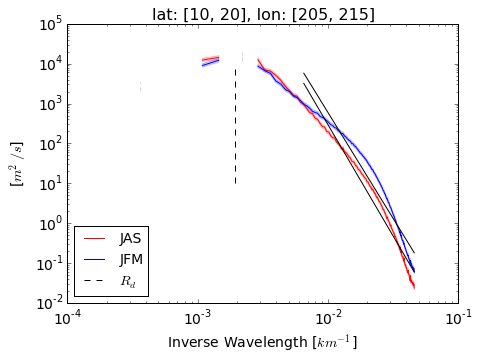

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


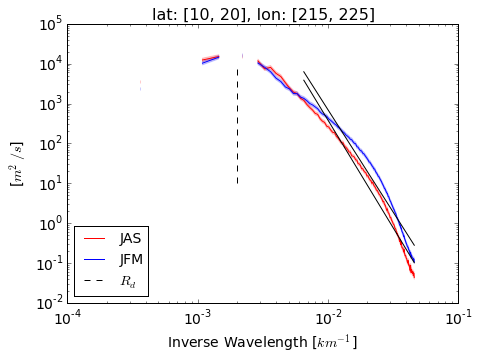

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


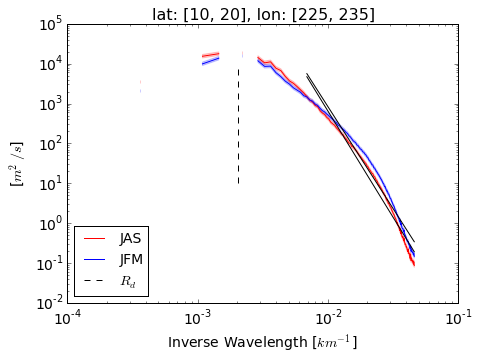

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


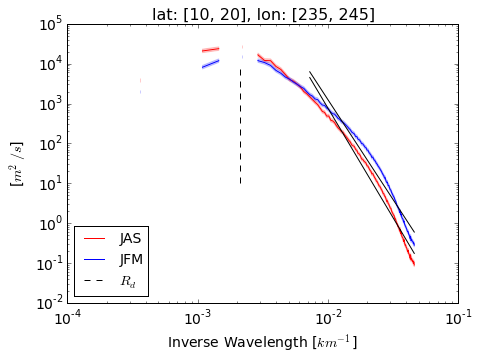

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


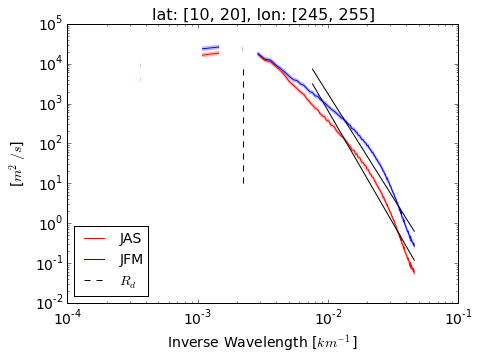

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


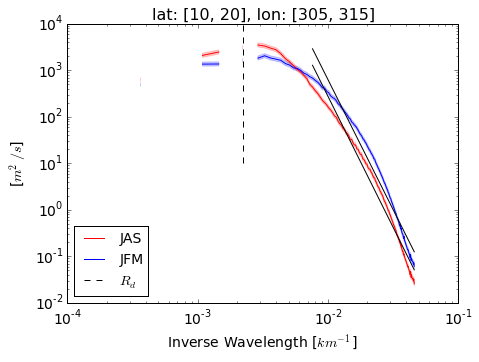

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


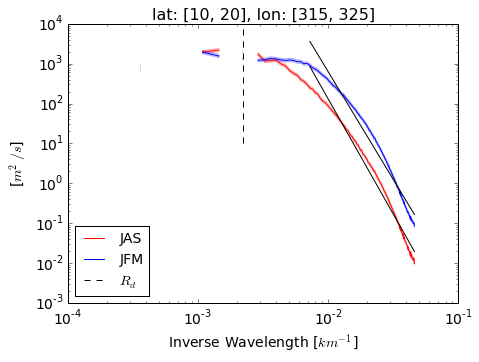

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


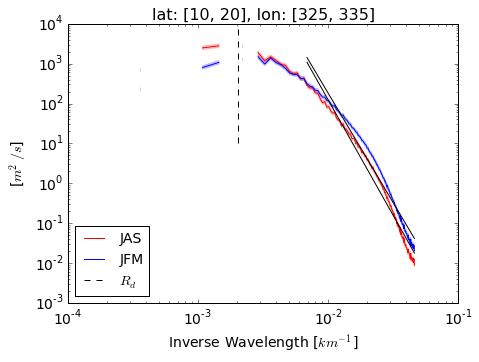

No plot of fit between 1-2 radii


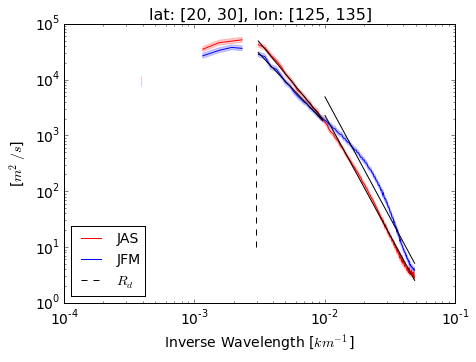

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


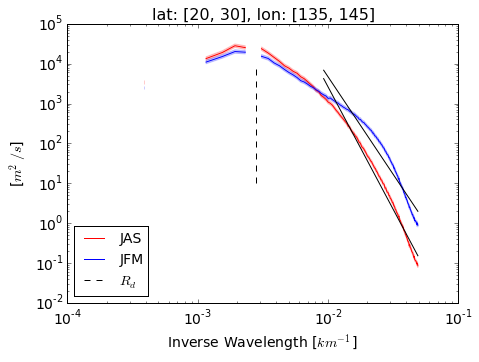

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


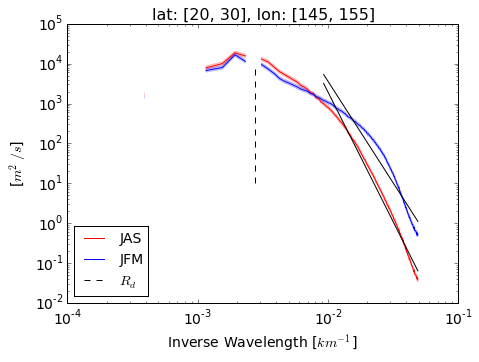

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


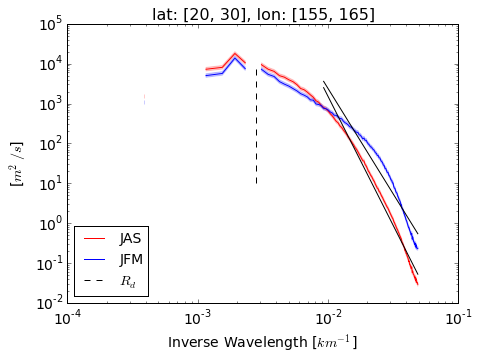

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


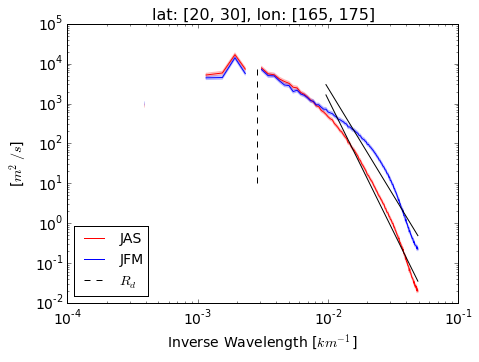

No plot of fit between 1-2 radii


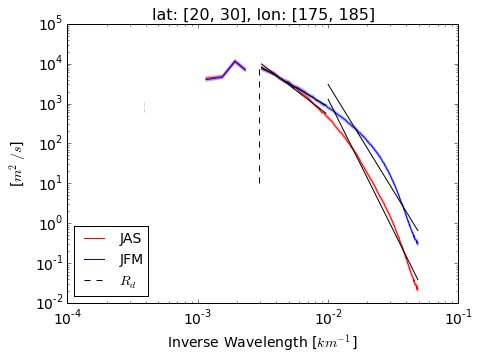

No plot of fit between 1-2 radii


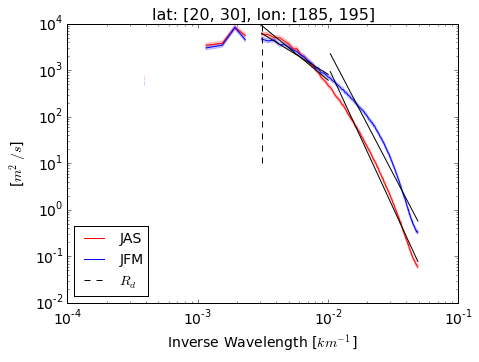

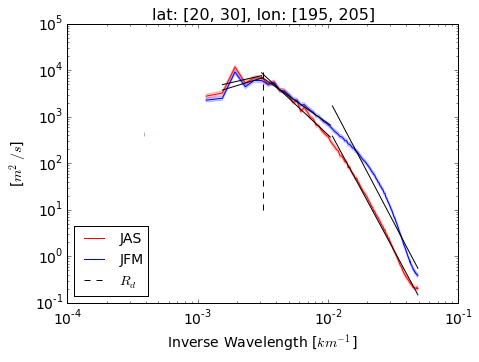

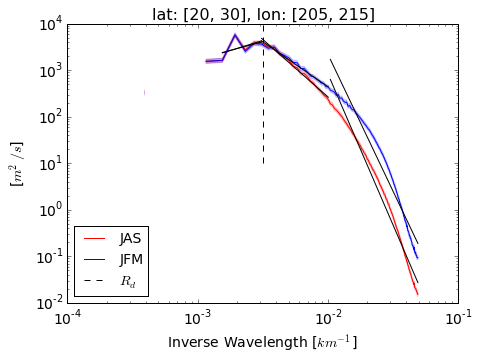

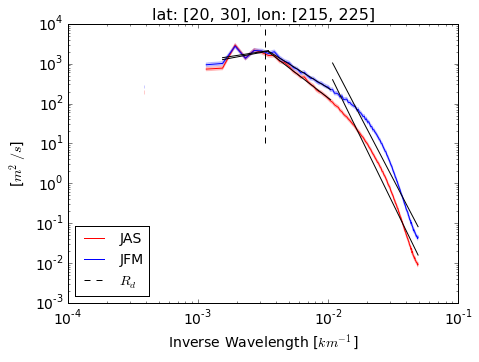

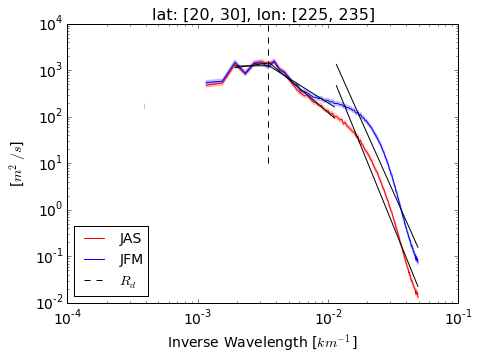

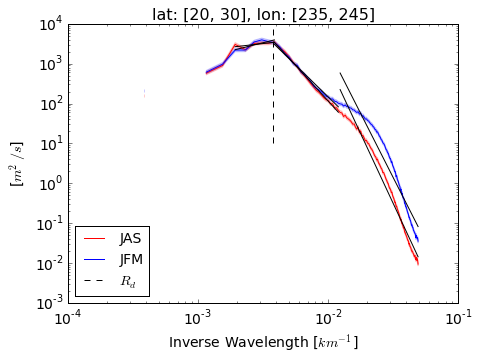

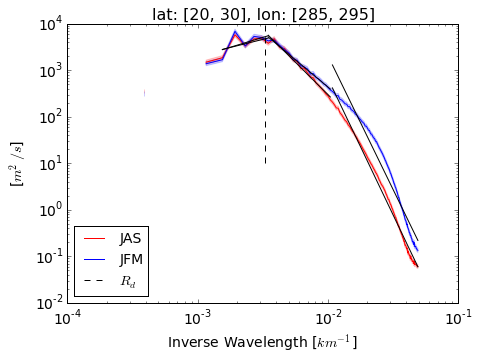

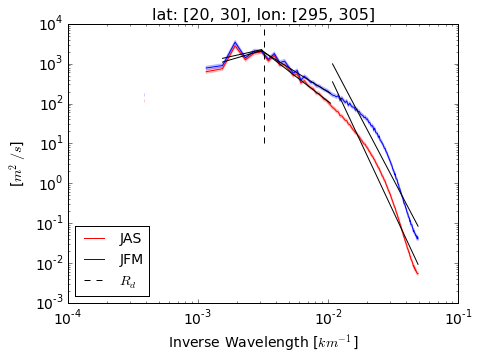

No plot of fit between 1-2 radii


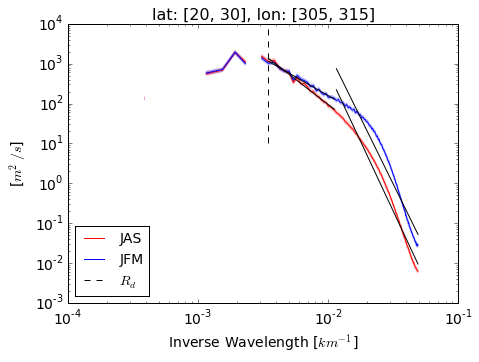

No plot of fit between 1-2 radii


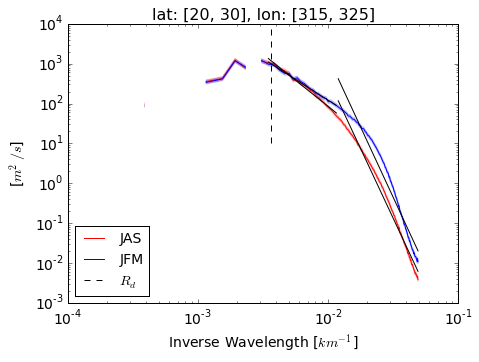

No plot of fit between 1-2 radii


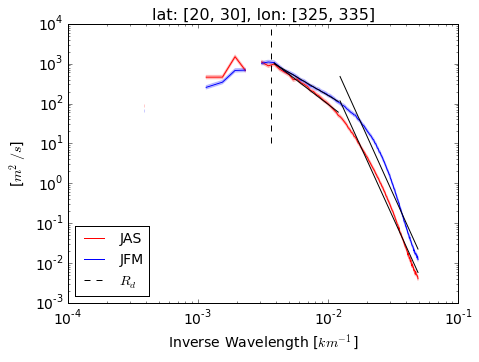

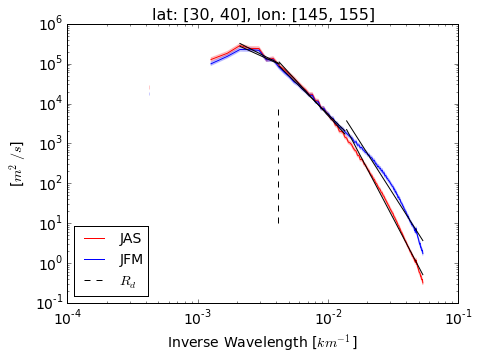

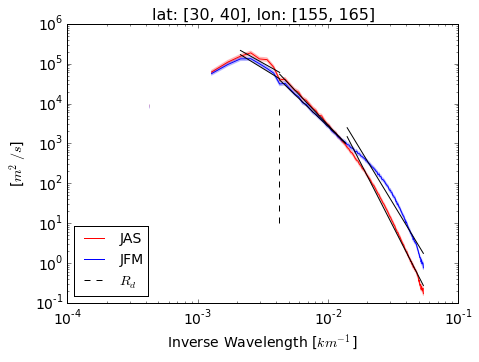

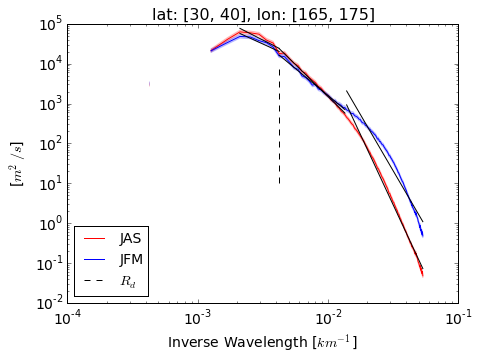

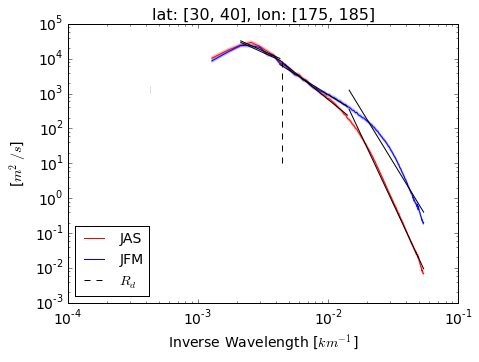

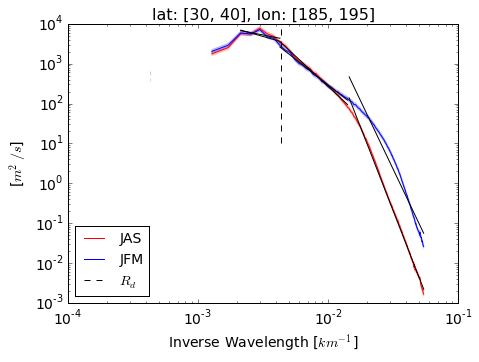

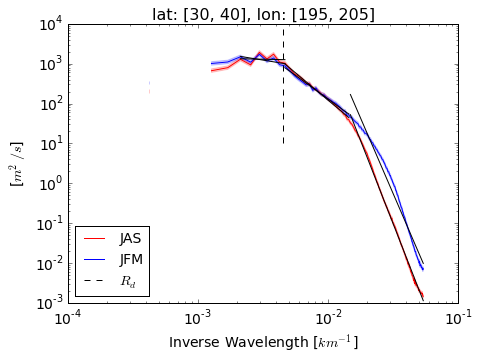

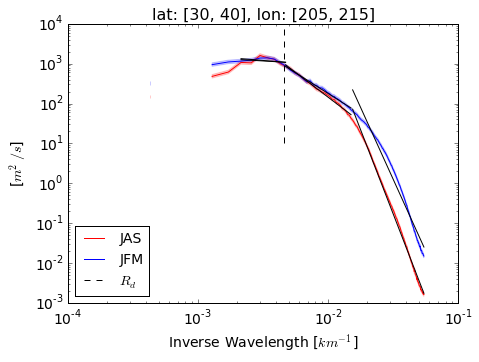

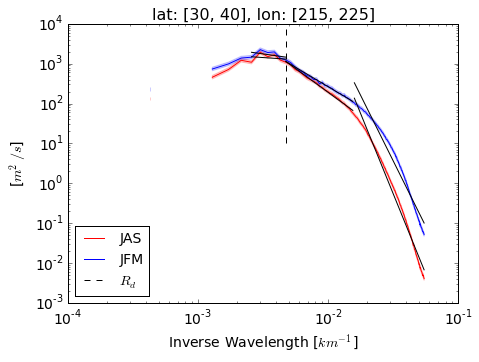

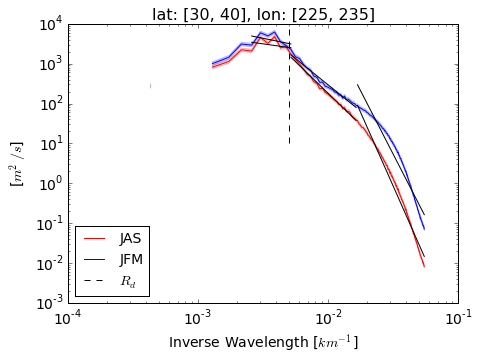

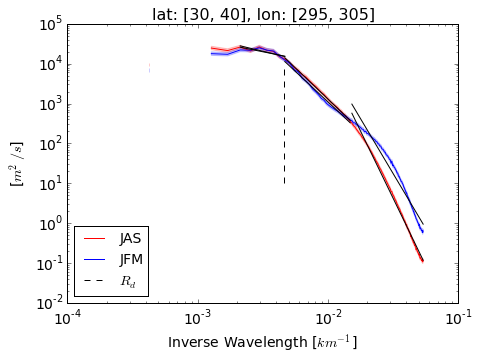

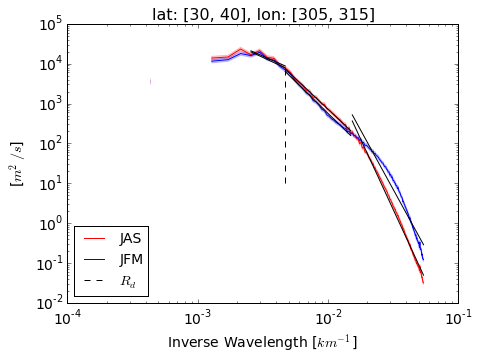

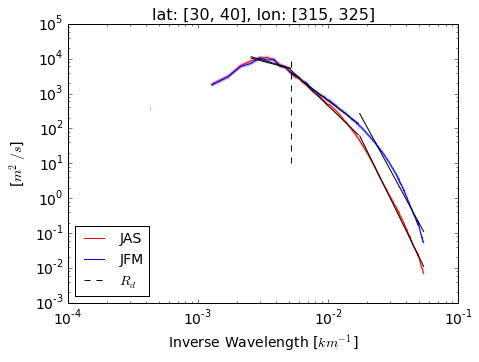

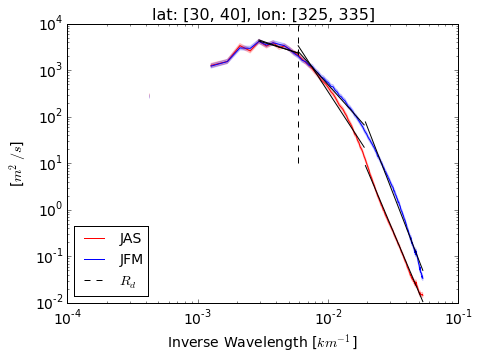

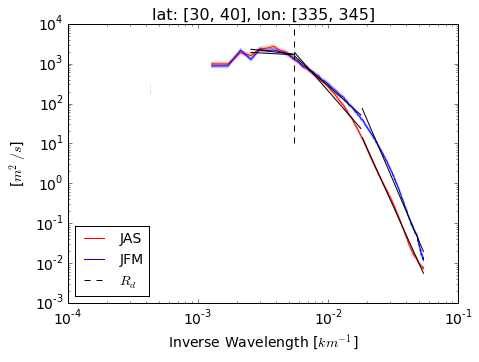

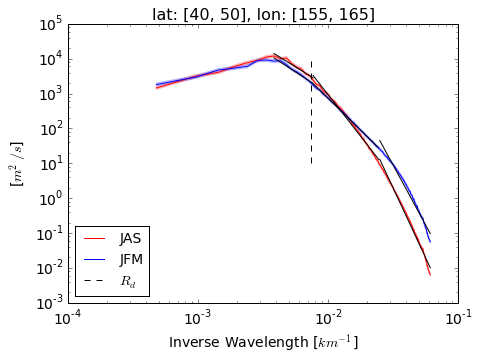

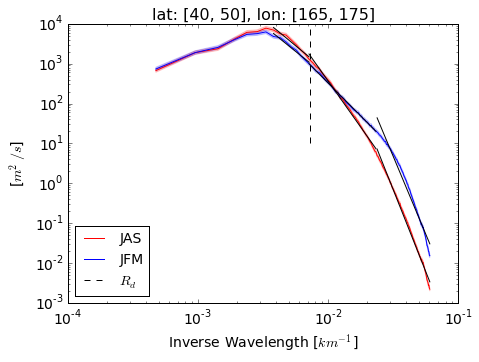

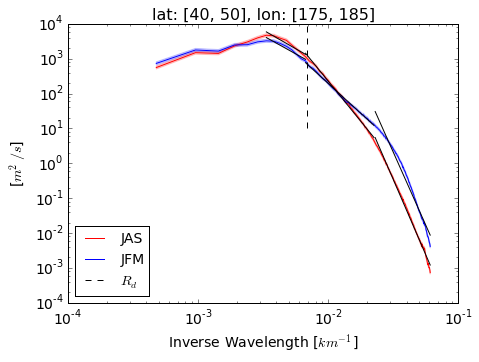

No plot of fit between 1-2 radii


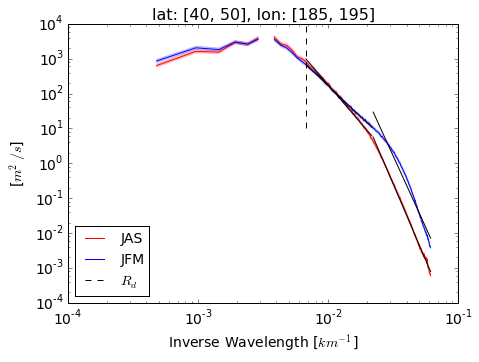

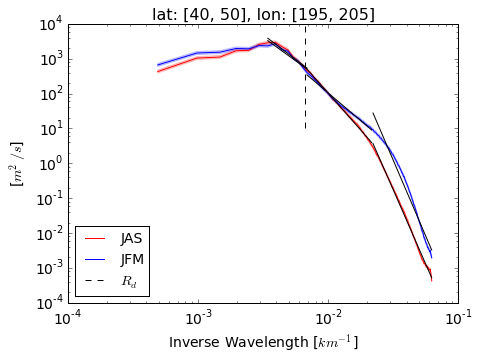

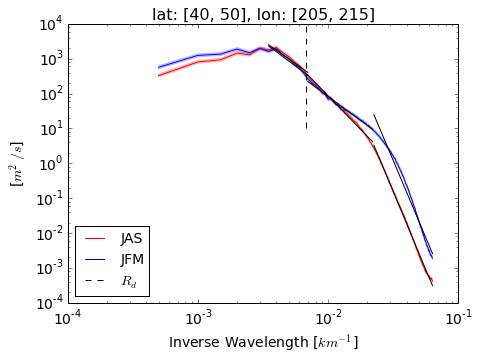

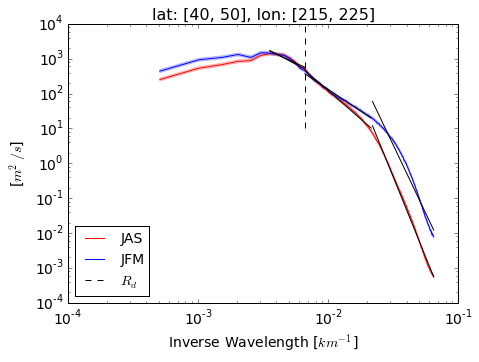

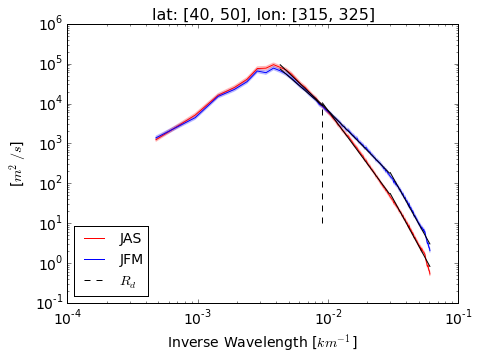

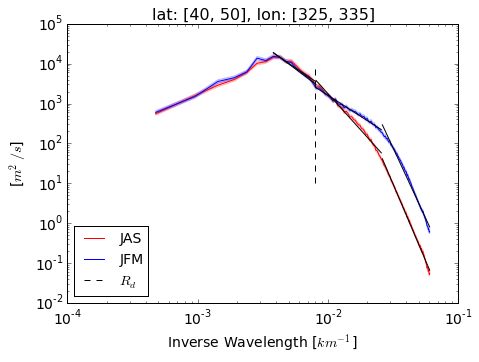

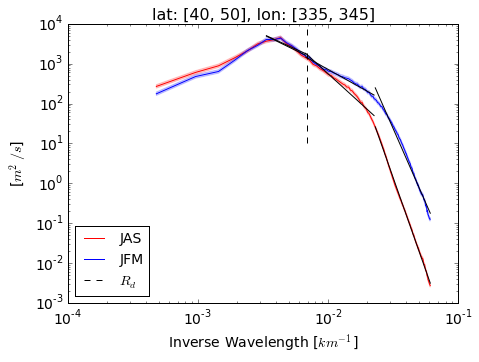

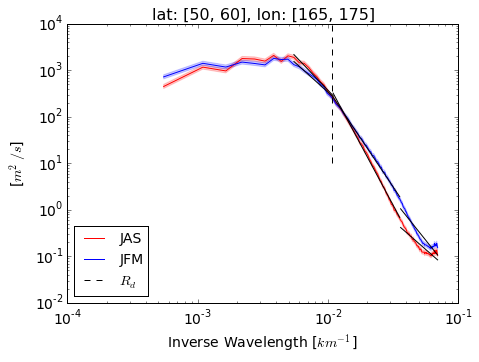

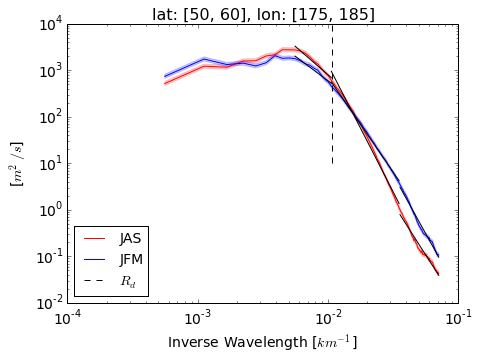

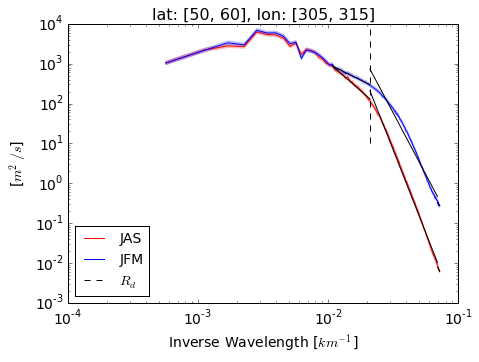

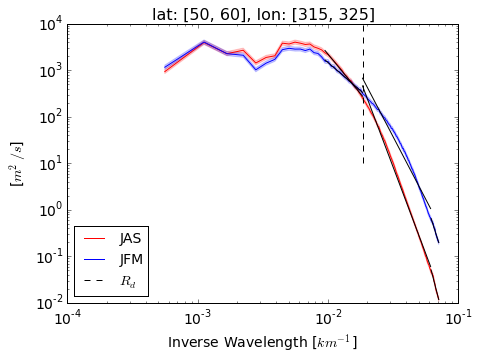

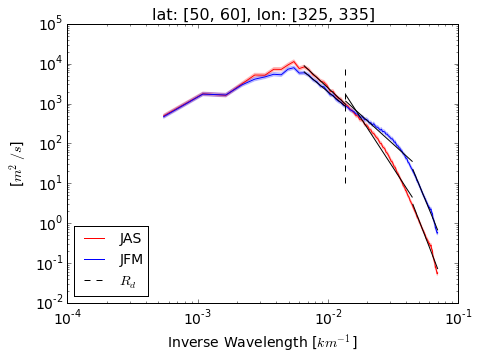

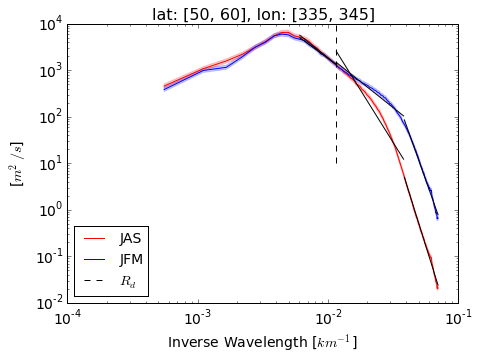

In [33]:
# x = 1e-2
# A = 1e1

for j in range(Degy+1):
    for i in range(Degx+1):
        
        Rx = Radii[j,i]*np.ones(100)
        Ry = np.linspace(1e1, 1e4, 100)
        
        if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i])) == False and np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i])) == False:
            
            fig = plt.figure(figsize=(7,5))
            
            ax = fig.add_subplot(111)
            ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_sum[(Degx+1)*j+i], 'r', label=r'JAS' )
            ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_win[(Degx+1)*j+i], 'b', label=r'JFM' )
            ax.fill_between( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, 
                            isospecs_ave_sum[(Degx+1)*j+i]*2*(Neff_Jul + Neff_Aug + Neff_Sep)*1/bSum,
                            isospecs_ave_sum[(Degx+1)*j+i]*2*(Neff_Jul + Neff_Aug + Neff_Sep)*1/aSum,
                            color='red', alpha=0.2)
            ax.fill_between( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, 
                            isospecs_ave_win[(Degx+1)*j+i]*2*(Neff_Jul + Neff_Aug + Neff_Sep)*1/bWin,
                            isospecs_ave_win[(Degx+1)*j+i]*2*(Neff_Jul + Neff_Aug + Neff_Sep)*1/aWin,
                            color='blue', alpha=0.2)
#             plt.figure(figsize=(7,5))
#             #plt.subplot(Degy+1,Degx+1,(Degx+1)*j+i+1)
#             plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_sum[(Degx+1)*j+i], 'r', label=r'JAS' )
#             plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_win[(Degx+1)*j+i], 'b', label=r'JFM' )
#             plt.loglog([x,x], A*err_bar, 'k.-', label=r'Error bar', basex=10, basey=10)
#             plt.loglog( np.reciprocal(Rx), Ry, 'k--', label=r'$R_d$' )
            ax.loglog( np.reciprocal(Rx), Ry, 'k--', label=r'$R_d$' )
            
            if np.all( np.isnan(psd_fit_sum_S[:,j,i]) ) == False or np.all( np.isnan(psd_fit_win_S[:,j,i]) ) == False:
#                 plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_S[:,j,i], 'k' )
#                 plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_S[:,j,i], 'k' )
                ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_S[:,j,i], 'k' )
                ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_S[:,j,i], 'k' )
            else:
                print 'No plot of fit between 0-0.5 radii'
            
            if np.all( np.isnan(psd_fit_sum_M[:,j,i]) ) == False or np.all( np.isnan(psd_fit_win_M[:,j,i]) ) == False:
#                 plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_M[:,j,i], 'k' )
#                 plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_M[:,j,i], 'k' )
                ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_M[:,j,i], 'k' )
                ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_M[:,j,i], 'k' )
            else:
                print 'No plot of fit between 0.5-1 radii'
                
            if np.all( np.isnan(psd_fit_sum_L[:,j,i]) ) == False or np.all( np.isnan(psd_fit_win_L[:+1,j,i]) ) == False:
#                 plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_L[:,j,i], 'k' )
#                 plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_L[:,j,i], 'k' )
                ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_L[:,j,i], 'k' )
                ax.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_L[:,j,i], 'k' )
            else:
                print 'No plot of fit between 1-2 radii'
                
            plt.legend(loc='lower left', fontsize=14)
            plt.title('lat: [%g, %g], lon: [%g, %g]' % (Lat[j,0], Lat[j+1,0], Lon[0,i], Lon[0,i+1]), fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel('Inverse Wavelength [$km^{-1}$]', fontsize=14)
            plt.ylabel('[$m^2/s$]', fontsize=14)
            plt.show()